#MASS DETECTION : 
##By Jaime Simarro, Ahmed Gouda , Zohaib Salahuddin, Anindiya Saha

## Set the enviroment


You can run it from colab using Google Drive or in your local computer (downloading the required files).  Required files are: 3 .npy files, all.txt, positives.txt, negatives.txt

For Google Colab:

In [0]:
from google.colab import drive
drive.mount('/content/drive/')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive/


Change to the Path of the folder in the drive

In [0]:
cd /content/drive/My\ Drive/

/content/drive/My Drive


## Preprocessing and Segmentation

**Set this variable to true if you want to generate the features for all the 407 cases.It will take some time. The Feature vectors have already been generated. They have been provided as files.**

In [0]:
extract_feat = False

### Usefull Functions : 
This contains functions for loading the data set, Morphological Sifting, Feature Extraction and Label Assignment

#### Parsed dataset

In [0]:
import numpy as np
import cv2
import os
import glob
import matplotlib.pyplot as plt
import math
from skimage.segmentation import slic
from skimage.segmentation import felzenszwalb
from skimage.segmentation import mark_boundaries
from skimage.util import img_as_uint
from skimage.util import img_as_float
from skimage.segmentation import slic
from skimage.segmentation import mark_boundaries
from skimage.util import img_as_float
import matplotlib.pyplot as plt
import numpy as np
import argparse
import cv2
import os
from skimage.morphology import disk, dilation, erosion
from skimage.feature import greycomatrix, greycoprops


def sortData(path="dataset"):
    """"
    Look in to the path in order to sort the data
        Input: 
            path
        Output:
            dic- of dic with the following fields:
                parsed[p] = {
                    'id':
                    'image':
                    'mask': 
                    'label':
                    'gt':}
        
    """
    flag_linux_system=  glob.glob(path+"/images\\*.tif")==[]

    # Getting directories path
    if flag_linux_system: # For Linux
        img_dir=glob.glob(path+"/images/*.tif")
        mask_dir = glob.glob(path+"/masks/*.png")
        gt_dir = glob.glob(path+"/groundtruth/*.tif")
        dir_replace="dataset/images/"
    else: # For Windows
        img_dir=glob.glob(path+"/images\\*.tif")
        mask_dir = glob.glob(path+"/masks\\*.png")
        gt_dir = glob.glob(path+"/groundtruth\\*.tif")
        dir_replace="dataset/images\\"
        
    print("Number of images:",len(img_dir))
    print("Number of mask:",len(mask_dir))
    print("Number of gt:",len(gt_dir))
    parsed={}
    for p in range(len(img_dir)):
        patient_id=img_dir[p].replace(".tif", "")
        
        patient_id=patient_id.replace(dir_replace, "")
        # Inilialization of the variables
        mask_path=[]
        label=False
        gt=[]
        s=[]
        g=[]
        # Looking in the mask directory
        for s in mask_dir:
            if (patient_id in s): # The is a match
                mask_path=s
        # Looking in the Ground Truth directory
        for g in gt_dir:
            if (patient_id in g):
                gt=g
                label=True
        # Creating list of dictionary                    
        parsed[p] = {
                    'id':patient_id,
                    'image': img_dir[p],
                    'mask': mask_path,
                    'label': label,
                    'gt': gt}
    return parsed

def findPatient(parsed,name, key='id'):
    """"
    Find a given pacient index in parsed using his id
    Input: 
        Parsed- dic of dic using to sort the data
        Key- key of the dic ('id','image','mask','label','gt')
        Value- usually id of the pacient but can be the path of the images (changing the key)
    Output:
        Index of the pacient
    """
    for i, dic in parsed.items():
        if dic[key] == name:        
            return i
    return -1




  # This function returns the labels for superpixels. According to the threshold assigned for each
  # scale, this function assigns the label to the super pixel. The thresholds are assigned so that the
  # sifted scale used to detect a specfic scales are respected.
  
def is_mass (superpixel,gt,seg,i):
    k=1.0
    for j in range(seg):
        num = 0
        test = np.sum(superpixel[gt[j,:,:]==k]==k)*2.0
        if (test > 100):
            num = test
        if (num != 0):
            break;

    segment_circularity =0
    den1 = (np.sum(superpixel[superpixel==k]==k))
    den2 = np.sum(gt[j,:,:][gt[j,:,:]==k]==k)
    ratio = (num / (den1 + den2))

    if i==0:
        if (den2 < 601):
            if (ratio > 0.5):
                print("ratio: " ,ratio)
                print(den2)
                return 1
            else :
                return 0
        else:
            return 0;

    if i==1:
        if ((den2 >600) & (den2 < 4501)):
            if (ratio > 0.45):
                print("ratio: " ,ratio)
                print(den2)
                return 1
            else :
                return 0
        else:
            return 0;

    if i== 2:
        if ((den2 > 4500) & (den2 < 11001)):
            if (ratio > 0.5):
                print("ratio: " ,ratio)
                print(den2)
                return 1
            else :
                return 0
        else:
            return 0 

    if i== 3:
        if (den2 > 11000):
            if (ratio > 0.55):
                print("ratio: " ,ratio)
                print(den2)
                return 1
            else :
                return 0
        else:
            return 0      

    
parsed=sortData(path="dataset")


Number of images: 410
Number of mask: 410
Number of gt: 107


####Multi scale morphological sifters

In [0]:
# Generate_rotate_kernel 

def Generate_rotated_kernel(D, delta_theta):
    kernel = np.zeros((D,D),dtype=int)
    for j in range(0,(D)): # Generate the kernel line
        kernel[int(D/2)][j] = 1
    rows,cols = kernel.shape
    rotmat = cv2.getRotationMatrix2D((int(D/2),int(D/2)), delta_theta, 1.0);  #Generate rotation matrix
    rotated_kernel = cv2.warpAffine(np.uint8(kernel), rotmat, (cols,rows));  #Rotate the kernel around its center
    #Remove the zeros rows and column
    rotated_kernel= np.delete(rotated_kernel,np.argwhere(np.all(rotated_kernel[..., :] == 0, axis=0)), axis=1)
    rotated_kernel= np.delete(rotated_kernel,np.where(~rotated_kernel.any(axis=1))[0], axis=0)
    return rotated_kernel

  
'''
This is the morphological sifters functions. This function takes the minimum and maximum area, total
number of lines. It retunrs the four sifted images
''' 
def Multi_scale_morphological_sifters (input_img ,M, N, Areamin, Areamax, PixelSize):

    SI = np.zeros((M+1), dtype=float) #Scale Interval
    D1 = np.zeros((M), dtype=int)  #Outer diameter
    D2 = np.zeros((M), dtype=int)  #Inner diameter

    DImin = 2 * math.sqrt(Areamin/math.pi)/(PixelSize*4)  #Calculate the minimum diameter
    DImax = 2 * math.sqrt(Areamax/math.pi)/(PixelSize*4)  #Calculate the maximum diameter
    
    SI[0] = 1.   #To get the minimum dimention in the first iteration
    
    #Calculate the circles diameters D1 and D2
    for i in range(1,M+1):
        SI[i] = ((DImax/DImin)**(1/M))**(i)
    for i in range(0,M):
        D1[i] = np.round(DImin * SI[i])
        if ((D1[i]%2) == 0):  #Make diameter odd number to use it as a kernel filer
            D1[i]+=1;
        D2[i] = np.round(DImin * SI[i+1])
        if ((D2[i]%2) == 0):  ##Make diameter odd number to use it as a kernel filer
            D2[i]+=1;
            
    sum_all_images = np.zeros((M,input_img.shape[0],input_img.shape[1]), dtype = int)

    for i in range(0,M):

        for delta_theta in range(0,180,int(180/N)):
            # Apply top-hat morphology using the outer diameter line
            rotated_kernel= Generate_rotated_kernel(D2[i], delta_theta)
            dst1 =  cv2.morphologyEx(input_img, cv2.MORPH_TOPHAT, rotated_kernel)
            # Apply opening morphology using the inner diameter line
            rotated_kernel= Generate_rotated_kernel(D1[i], delta_theta)
            dst2 =  cv2.morphologyEx(dst1, cv2.MORPH_OPEN, rotated_kernel)
            
            sum_all_images[i,:,:] = sum_all_images[i,:,:] + dst2;  #Sum all images each sifter line
        
        sum_all_images[i,:,:] = (sum_all_images[i,:,:]/np.max(sum_all_images[i,:,:]))*(2**16-1) #Normalize the output image
    return sum_all_images



#### Feature extraction

In [0]:

def extract_features(original_img,clahe_img,super_pixel,index,mms):
    #original_img : the original img without any preprocessing
    #clahe_img : the image after preprocessing
    #superpixel: the superpixel whose features are to be calculated
    #index: index is the scale of mms
    #mms: this is the morphological sifted image
    ep = 0.001
    
  #Features: 1: These calculate the ratio between the boundaries of the 
  # sifted , enhanced images. Outer boundary, Inner Boundary and the core
  # of the super pixel is taken into account.
#############################################################
    # for calculating t1, t2, t3 , t4, t5, t6
    e_mass = [ 0.2*24 , 0.2*31,  0.2*63, 0.2*123]
    
    cl1 = clahe_img
    cl1_mod = cl1/(2**16-1)  
    
    near_img_mod = original_img/((2**16-1))
    
    temp = super_pixel
    so_0 = np.multiply(near_img_mod,temp)
    so_0 = np.sum(so_0)
    se_0 = np.multiply(cl1_mod,temp)
    se_0 = np.sum(se_0)
    sm_0 = np.multiply(mms,temp)
    sm_0 = np.sum(sm_0)
    
    temp_t = temp.astype(np.uint8)
    temp2 = cv2.erode(temp_t,disk(e_mass[index]),iterations = 1)
    temp3 = cv2.dilate(temp_t,disk(e_mass[index]),iterations = 1)

    temp2 = temp2.astype(temp.dtype)
    temp3 = temp3.astype(temp.dtype)
    
    so_1 = np.multiply(near_img,temp2)
    so_1 = np.sum(so_1)
    se_1 = np.multiply(cl1_mod,temp2)
    se_1 = np.sum(se_1)
    sm_1 = np.multiply(mms,temp2)
    sm_1 = np.sum(sm_1) 

    boundary1 = temp ^ temp2
    so_2 = np.multiply(near_img_mod,boundary1)
    so_2 = np.sum(so_2)
    se_2 = np.multiply(cl1_mod,boundary1)
    se_2 = np.sum(se_2)
    sm_2 = np.multiply(mms,boundary1)
    sm_2 = np.sum(sm_2) 

    boundary2 = temp3 ^ temp
    so_3 = np.multiply(near_img_mod,boundary2)
    so_3 = np.sum(so_3)
    se_3 = np.multiply(cl1_mod,boundary2)
    se_3 = np.sum(so_3)
    sm_3 = np.multiply(mms,boundary2)
    sm_3 = np.sum(sm_3)     

    
    if(so_1 == 0):
        so_1 = ep

    if(se_1 == 0):
        se_1 = ep
        
    if(so_2 == 0):
        so_2 = ep
     
    if(se_2 == 0):
        se_2 = ep
        
    if(so_0 == 0):
        so_0 = ep
        
    if(se_0 == 0):
        se_0 = ep

    if(sm_2 == 0):
        sm_2 = ep
        
    if(sm_1 == 0):
        sm_1 = ep
        
    if(sm_0 == 0):
        sm_0 = ep
        
    t1 = [(so_1-so_2)/(so_1),(se_1-se_2)/(se_1)]
    t2 = [(so_2-so_3)/(so_2),(se_2-se_3)/(se_2)]
    t3 = [(so_0-so_3)/(so_0),(se_0-se_3)/(se_0)] 
    
    m1 = (sm_1-sm_2)/(sm_1)
    m2 = (sm_2-sm_3)/(sm_2)
    m3 = (sm_0-sm_3)/(sm_0)
    
    #Features 2: These are textural features that are being used
###############################################################
    
    mask_idx = super_pixel
    segment_region = np.multiply(original_img,mask_idx)
    comp_temp = ma.array(segment_region,mask=~mask_idx)
    comp_temp = comp_temp.astype('uint8')
    comp_temp= np.delete(comp_temp,np.argwhere(np.all(comp_temp[..., :] == 0, axis=0)), axis=1)
    comp_temp= np.delete(comp_temp,np.where(~comp_temp.any(axis=1))[0], axis=0)
    comp_temp= np.delete(comp_temp,np.argwhere(np.all(comp_temp[..., :] == 0, axis=0)), axis=1)
    comp_temp= np.delete(comp_temp,np.where(~comp_temp.any(axis=1))[0], axis=0)

    
    compressed_segment_region = ma.array(segment_region,mask=~mask_idx).compressed()
    glcm = greycomatrix(comp_temp, [5], [0], 256)
    stats = ["dissimilarity", "correlation", "contrast", "homogeneity", "ASM", "energy"]
    dissimilarity = greycoprops(glcm,stats[0])[0,0]
    correlation = greycoprops(glcm,stats[1])[0,0]
    contrast = greycoprops(glcm,stats[2])[0,0]
    homogeneity = greycoprops(glcm,stats[3])[0,0]
    ASM = greycoprops(glcm,stats[4])[0,0]
    energy = greycoprops(glcm,stats[5])[0,0]

    #Features 3 : These are the intensity features that are being used
#################################################################################

    segment_mean = np.mean(compressed_segment_region)
    segment_skew = skew(compressed_segment_region)
    segment_kurtosis = kurtosis(compressed_segment_region)
    segment_area = (compressed_segment_region.size)/(mask_idx.size)  ###

    #Features 4: These are the shape features that are being used
################################################################################
    mask_idx_uint8 =  mask_idx.astype(np.uint8)
    _,contours, hierarchy = cv2.findContours(mask_idx_uint8, 1, 2)
    cnt = contours[0]

    segment_perimeter = cv2.arcLength(cnt,True)/(mask_idx.size)**0.5
    segment_circularity = 4 * math.pi * segment_area / (segment_perimeter)**2
    
    cnt_area = cv2.contourArea(cnt)
    x,y,w,h = cv2.boundingRect(cnt)
    rect_area = w*h
    segment_extent = float(cnt_area)/(rect_area + ep)

    hull = cv2.convexHull(cnt)
    hull_area = cv2.contourArea(hull)
    segment_solidity = float(cnt_area)/(hull_area + ep)

    (_,_),segment_radius = cv2.minEnclosingCircle(cnt)

    
 
    if (len(cnt)>5):
      (x, y), (MA, ma1), angle = cv2.fitEllipse(cnt)
      a = ma1/2
      b = MA/2
      segment_eccentricity = np.sqrt(1-pow(b/a, 2))
    else:
      segment_eccentricity = -1
    #Features 5 MMS : These are the features for the multiscale morphologically
    # sifted images.
################################################################################    
    
    mask_idx = super_pixel
    segment_region_mms = np.multiply(mms,mask_idx)
    compressed_segment_region_mms = ma.array(segment_region_mms,mask=~mask_idx).compressed()
    segment_mean_mms = np.mean(compressed_segment_region_mms)
    segment_skew_mms = skew(compressed_segment_region_mms)
    segment_kurtosis_mms = kurtosis(compressed_segment_region_mms)
    segment_area_mms = (compressed_segment_region_mms.size)/(mask_idx.size)  ###

    mask_idx_uint8 =  mask_idx.astype(np.uint8)
    _,contours, hierarchy = cv2.findContours(mask_idx_uint8, 1, 2)
    cnt = contours[0]

    segment_perimeter_mms = cv2.arcLength(cnt,True)/(mask_idx.size)**0.5
    segment_circularity_mms = 4 * math.pi * segment_area_mms / (segment_perimeter_mms)**2
    
    segment_smoothness_mms = 1- 1/(1 + np.var(compressed_segment_region_mms/2**16))
    segment_histogram_mms = np.histogram(compressed_segment_region_mms, bins=2**8, range=(0,(2**16)-1), density=True)
    segment_histogram_prob_mms = segment_histogram_mms[0]/sum(segment_histogram_mms[0])
    segment_uniformity_mms = sum(segment_histogram_prob_mms**2);  
    
    #Features 6 Entropy, Uniformity,smoothness
##################################################################################
    rect = cv2.minAreaRect(cnt)
    box = cv2.boxPoints(rect)
    box = np.int0(box)
    cv2.drawContours(segment_area,[box],0,(0,0,255),2)
    box_length1 = (abs(box[0,0]-box[1,0])**2+abs(box[0,1]-box[1,1])**2)**0.5
    box_length2 = (abs(box[1,0]-box[2,0])**2+abs(box[1,1]-box[2,1])**2)**0.5
    box_length3 = (abs(box[2,0]-box[3,0])**2+abs(box[2,1]-box[3,1])**2)**0.5
    box_length4 = (abs(box[3,0]-box[0,0])**2+abs(box[3,1]-box[0,1])**2)**0.5
    if (box_length1 <= box_length2):
        segment_ratio = box_length1/box_length2
    elif (box_length2 < box_length1):
        segment_ratio = box_length2/box_length1
        
    segment_smoothness = 1- 1/(1 + np.var(compressed_segment_region/2**16))
    segment_histogram = np.histogram(compressed_segment_region, bins=2**8, range=(0,(2**16)-1), density=True)
    segment_histogram_prob = segment_histogram[0]/sum(segment_histogram[0])
    segment_uniformity = sum(segment_histogram_prob**2);

    segment_single_entropy = np.zeros((len(segment_histogram_prob)), dtype = float)
    for i in range(len(segment_histogram_prob)):
        if(segment_histogram_prob[i] == 0):
            segment_single_entropy[i] = 0;
        else:
            segment_single_entropy[i] = segment_histogram_prob[i]*np.log2(segment_histogram_prob[i]);
    segment_entropy = -(segment_histogram_prob*segment_single_entropy).sum()
    
    
###############################################################

 
    features = [segment_mean, segment_skew , segment_area, segment_perimeter,
                segment_ratio, segment_smoothness, segment_uniformity,segment_entropy
                , t1[0],t1[1],t2[0],t2[1],t3[0],t3[1]
                ,dissimilarity, correlation, contrast, homogeneity, ASM, energy
                ,segment_mean_mms, segment_skew_mms, segment_area_mms, segment_perimeter_mms
                ,segment_extent,segment_solidity,segment_radius,segment_eccentricity
                ,m1,m2,m3,segment_smoothness_mms,segment_uniformity_mms,
                segment_kurtosis,segment_kurtosis_mms,segment_circularity,segment_circularity_mms]
    
    
    return features

  

Read all the patients all Names

In [0]:
parsed=sortData(path="dataset")

with open("all.txt") as f:
  all_inst = f.readlines()     
for p in range(len(all_inst)):
  all_inst[p]=all_inst[p].replace(".tif\n", "")

Number of images: 410
Number of mask: 410
Number of gt: 107


Read the positive and negative name file

In [0]:
# This function returns the patient dictionary p.
# Index is the number of patient in the list

def get_patients(parsed,patient_choice):
    
  if (patient_choice == 'n'):
    with open("negatives.txt") as f:
      negatives = f.readlines()     
    for p in range(len(negatives)):
      negatives[p]=negatives[p].replace(".tif\n", "")
    return negatives
    
  if (patient_choice == 'p'):
    with open("positives.txt") as f:
      positives = f.readlines()     
    for p in range(len(positives)):
      positives[p]=positives[p].replace(".tif\n", "")
    return positives
  


The indices in the feature vector, these are used to keep track of the superpixels patients and sifted scale in order to come back to the patients to analyze the results

In [0]:
feature_limit= 36 #included
index_patient = 37
index_sifted_scale = 38
index_superpixel = 39


#### Get feature vector_postive
This function returns the positive and negative feature vectors for the specified patients: This is used for Cross Validation

In [0]:
#returns  positive and negative features from the positive feature instances
def get_feature_vector_postive(p_nfeatures,p_pfeatures,p_start,p_stop):
  true_sp = []
  false_sp =[]
  count_f = 0
  count_t = 0
  for i in range(p_start,p_stop):
    for values in p_nfeatures[i]:
      values = np.expand_dims(values,axis=0)
      if (count_f == 0):
        count_f = count_f + 1
        false_sp = values
      else:
        false_sp = np.concatenate((false_sp,values),axis = 0)
     
    for values in p_pfeatures[i]:
      values = np.expand_dims(values,axis=0)
      if (count_t == 0):
        count_t = count_t + 1
        true_sp = values
      else:
        true_sp = np.concatenate((true_sp,values),axis = 0)
      
  return true_sp,false_sp

#returns  positive and negative features from the positive feature instances
def get_feature_vector_negative(n_features,p_start,p_stop):
  false_sp =[]
  count_f = 0
  for i in range(p_start,p_stop):
    for values in n_features[i]:
      values = np.expand_dims(values,axis=0)
      if (count_f == 0):
        count_f = count_f + 1
        false_sp = values
      else:
        false_sp = np.concatenate((false_sp,values),axis = 0)
    
  return false_sp
  

## Feature extraction
DO **NOT RUN A** titles

####  A- Positives Feature Extraction:
All the segmentation of the masses is shown for all the patients. These detected super pixels for each of the positive patients are assigned the label 1. (You **dont need to run** this as the feature vectors have already been generated and been provided.)

PATIENT NO: 0
ratio:  0.879162702188392
567
Scale:  0


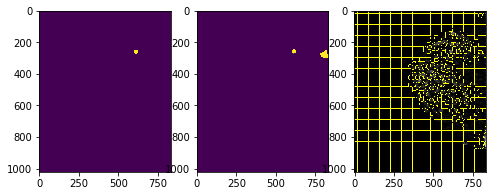

ratio:  0.8792643132601602
1785
Scale:  1


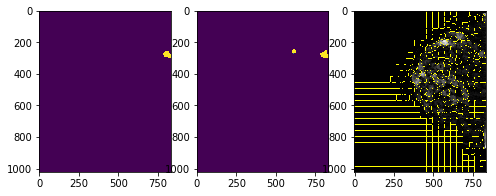

HERE:  0
PATIENT NO: 1
ratio:  0.8557844690966719
1063
Scale:  1


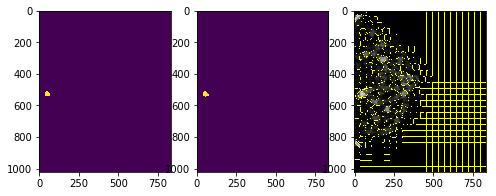

HERE:  1
PATIENT NO: 2
ratio:  0.8140417457305503
556
Scale:  0


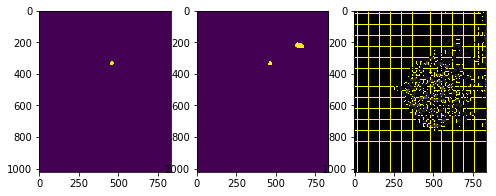

ratio:  0.8557388557388558
1600
Scale:  1


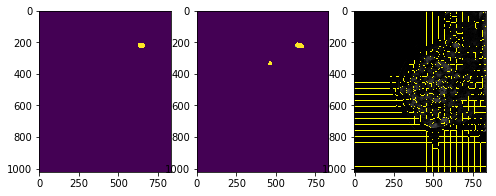

HERE:  2
PATIENT NO: 3
ratio:  0.8420221169036335
1234
Scale:  1


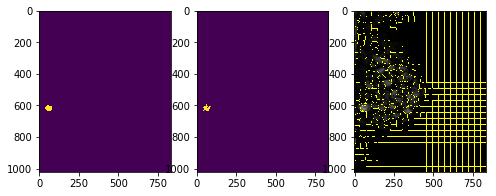

HERE:  3
PATIENT NO: 4
ratio:  0.49572649572649574
2359
Scale:  1


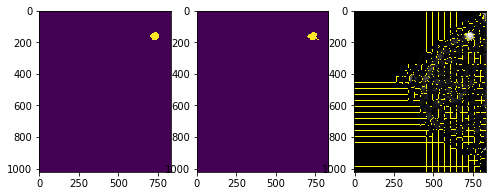

ratio:  0.678801456174741
2359
Scale:  1


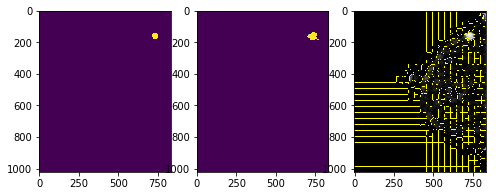

HERE:  4
PATIENT NO: 5
ratio:  0.742001361470388
2755
Scale:  1


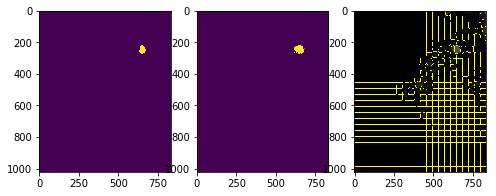

HERE:  5
PATIENT NO: 6
ratio:  0.8248095756256801
1071
Scale:  1


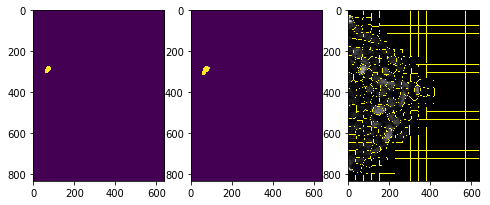

HERE:  6
PATIENT NO: 7
ratio:  0.7054714784633295
729
Scale:  1


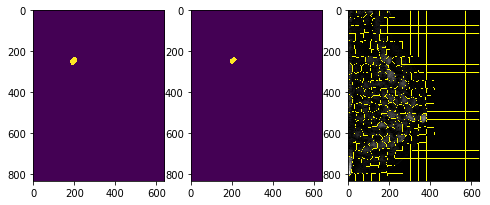

HERE:  7
PATIENT NO: 8
ratio:  0.59063160715881
19351
Scale:  3


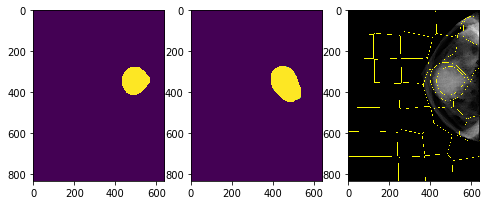

HERE:  8
PATIENT NO: 9
ratio:  0.8073277087875628
24138
Scale:  3


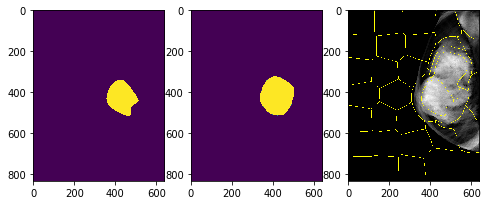

HERE:  9
PATIENT NO: 10
ratio:  0.7420042643923241
977
Scale:  1


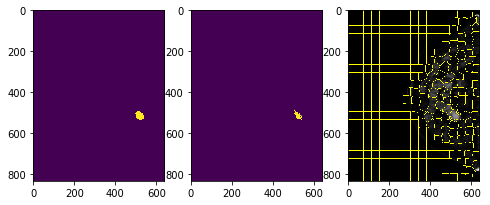

HERE:  10
PATIENT NO: 11
ratio:  0.8145421076852278
938
Scale:  1


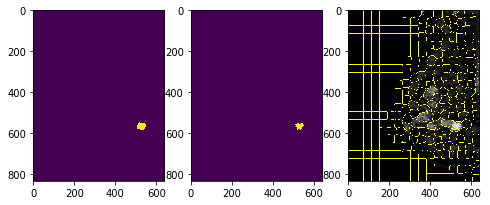

HERE:  11
PATIENT NO: 12
ratio:  0.7918486171761281
1637
Scale:  1


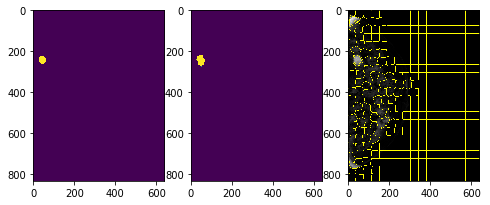

HERE:  12
PATIENT NO: 13
ratio:  0.80779518532671
1490
Scale:  1


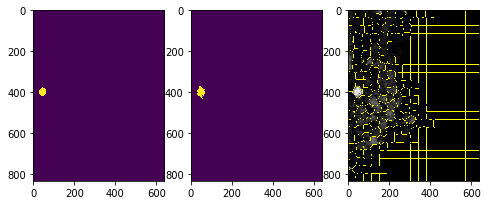

HERE:  13
PATIENT NO: 14
ratio:  0.6871605697305052
6406
Scale:  2


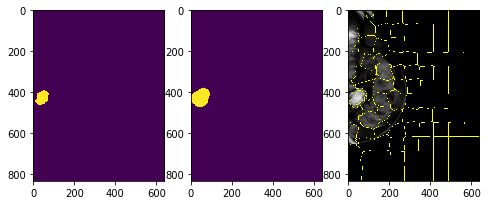

HERE:  14
PATIENT NO: 15
ratio:  0.8614232209737828
5062
Scale:  2


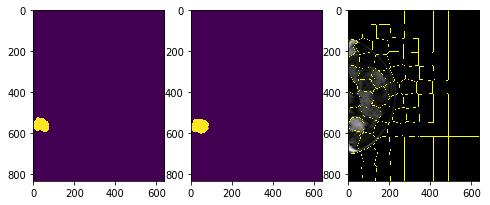

HERE:  15
PATIENT NO: 16
ratio:  0.6959493488740197
17954
Scale:  3


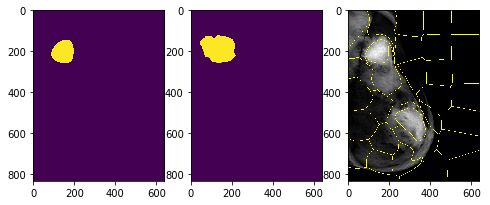

HERE:  16
PATIENT NO: 17
ratio:  0.693920420117148
16166
Scale:  3


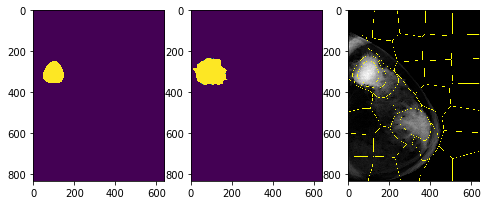

HERE:  17
PATIENT NO: 18
ratio:  0.7651446803828804
28059
Scale:  3


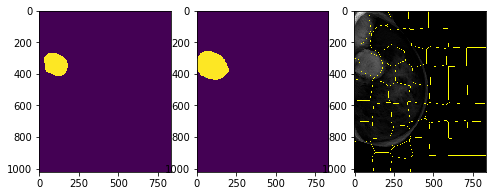

HERE:  18
PATIENT NO: 19
ratio:  0.5311355311355311
2188
Scale:  1


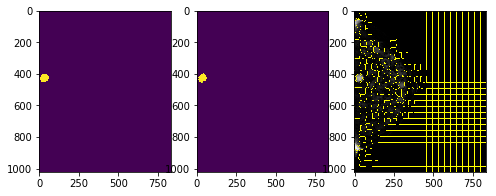

ratio:  0.7003267003267003
2188
Scale:  1


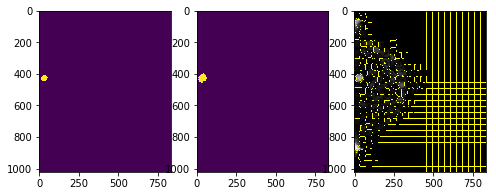

HERE:  19
PATIENT NO: 20
ratio:  0.8709576138147567
1715
Scale:  1


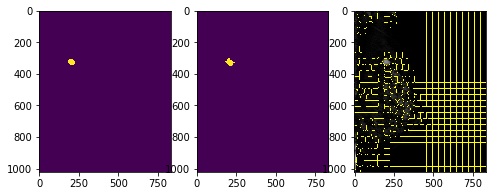

HERE:  20
PATIENT NO: 21
ratio:  0.7168195718654434
681
Scale:  1


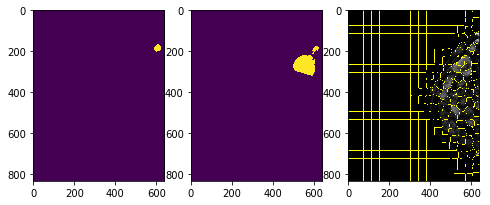

ratio:  0.5149527136406237
8299
Scale:  2


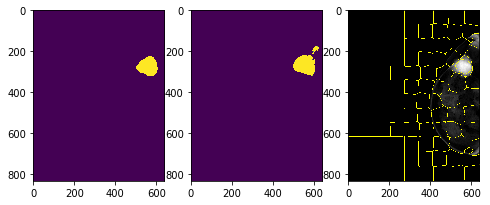

ratio:  0.6342466880605612
8299
Scale:  2


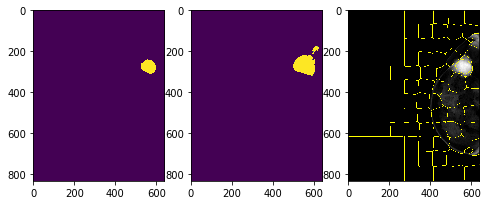

HERE:  21
PATIENT NO: 22
ratio:  0.8383900928792569
767
Scale:  1


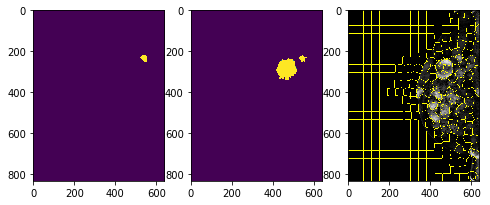

ratio:  0.6239354549529359
7675
Scale:  2


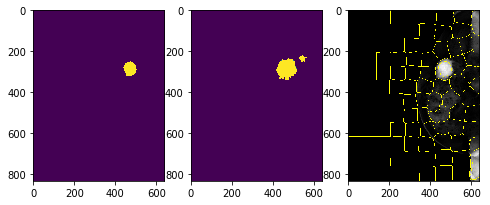

HERE:  22
PATIENT NO: 23
ratio:  0.7683755404570722
4985
Scale:  2


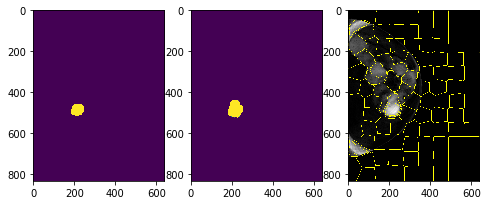

HERE:  23
PATIENT NO: 24
ratio:  0.5253156644580572
5000
Scale:  2


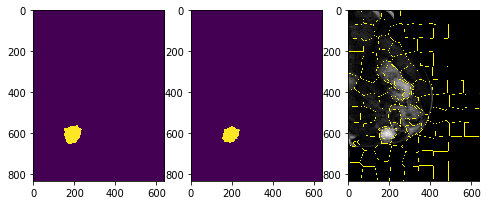

ratio:  0.7106756059824652
5000
Scale:  2


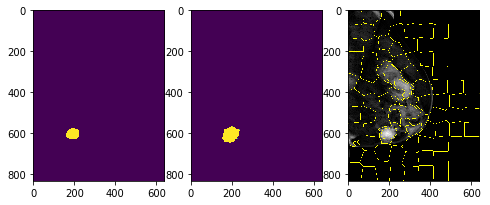

HERE:  24
PATIENT NO: 25
ratio:  0.8029411764705883
2021
Scale:  1


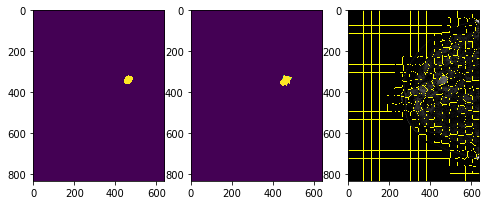

HERE:  25
PATIENT NO: 26
ratio:  0.7970547630004602
1283
Scale:  1


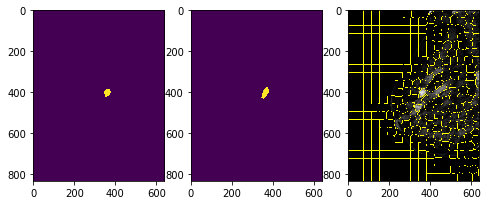

HERE:  26
PATIENT NO: 27
ratio:  0.7684335208765176
7892
Scale:  2


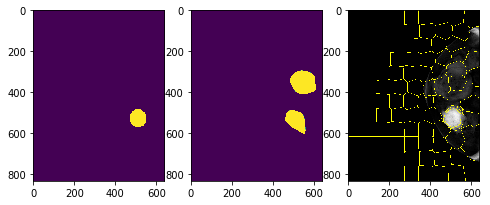

ratio:  0.7233031674208145
11489
Scale:  3


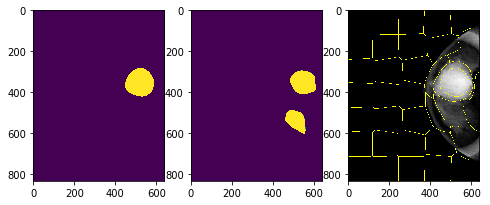

HERE:  27
PATIENT NO: 28
ratio:  0.8779979144942649
1009
Scale:  1


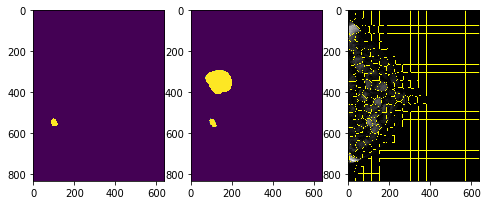

ratio:  0.6556180527655016
11555
Scale:  3


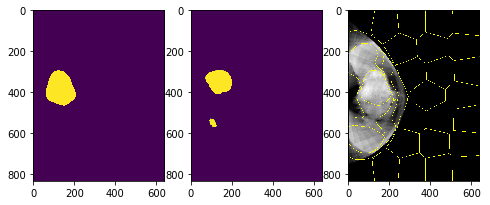

HERE:  28
PATIENT NO: 29
ratio:  0.7360447417790521
13104
Scale:  3


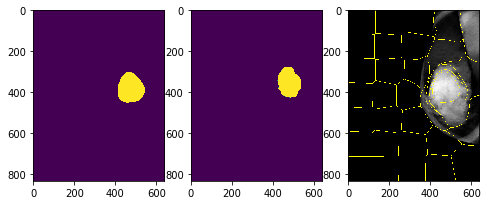

HERE:  29
PATIENT NO: 30
ratio:  0.647167614220152
9824
Scale:  2


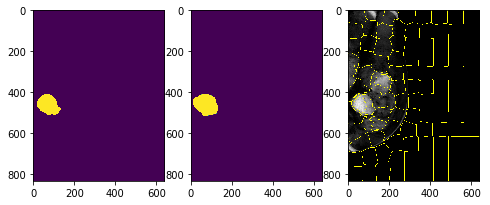

ratio:  0.523927578694313
9824
Scale:  2


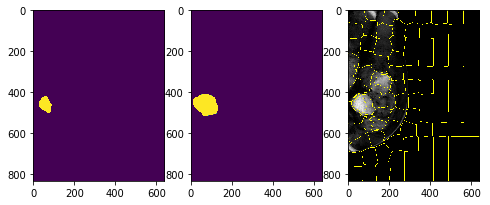

HERE:  30
PATIENT NO: 31
ratio:  0.6811588132635253
47231
Scale:  3


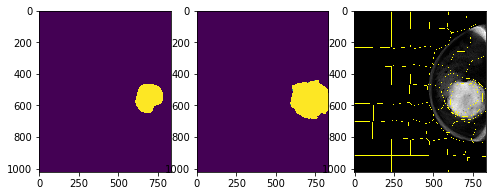

HERE:  31
PATIENT NO: 32
ratio:  0.7490118577075099
528
Scale:  0


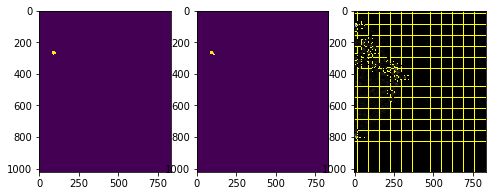

HERE:  32
PATIENT NO: 33
ratio:  0.713201251303441
30850
Scale:  3


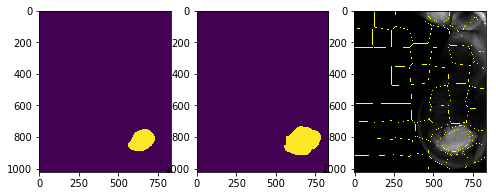

HERE:  33
PATIENT NO: 34
ratio:  0.8008130081300813
796
Scale:  1


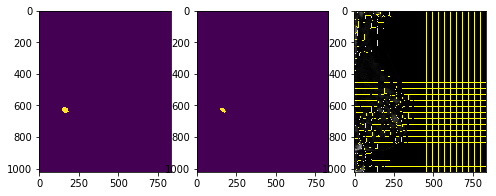

HERE:  34
PATIENT NO: 35
ratio:  0.7919635045619298
14700
Scale:  3


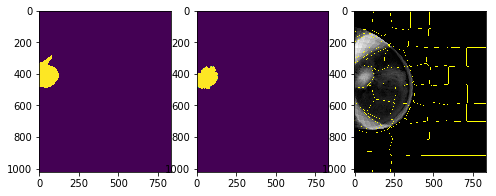

HERE:  35
PATIENT NO: 36
ratio:  0.8239352527530848
12501
Scale:  3


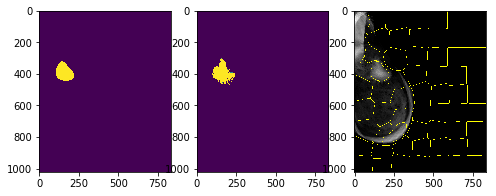

HERE:  36
PATIENT NO: 37
ratio:  0.8185689948892675
972
Scale:  1


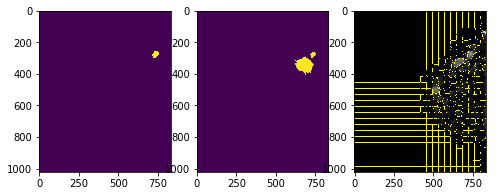

ratio:  0.7433841218925421
8304
Scale:  2


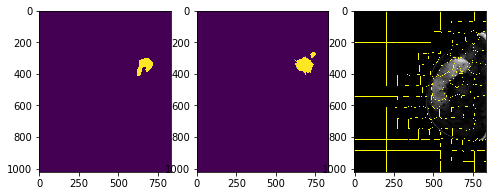

HERE:  37
PATIENT NO: 38
ratio:  0.5620395502132609
7295
Scale:  2


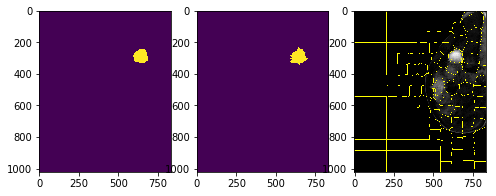

ratio:  0.6389925373134329
7295
Scale:  2


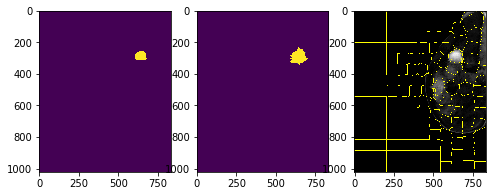

HERE:  38
PATIENT NO: 39
ratio:  0.6962778204144282
6795
Scale:  2


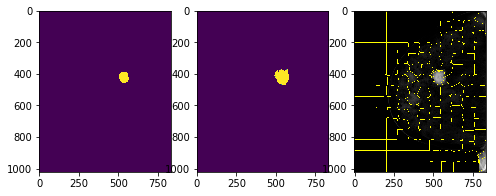

HERE:  39
PATIENT NO: 40
ratio:  0.6440464404644046
7533
Scale:  2


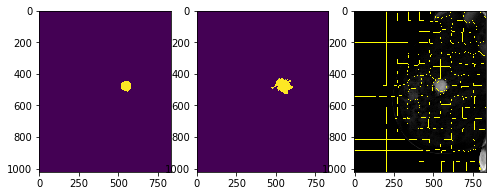

HERE:  40
PATIENT NO: 41
ratio:  0.5618579723090665
3220
Scale:  1


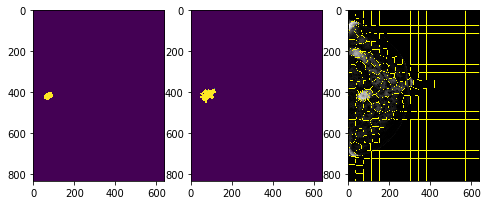

HERE:  41
PATIENT NO: 42
ratio:  0.46224890325559914
3091
Scale:  1


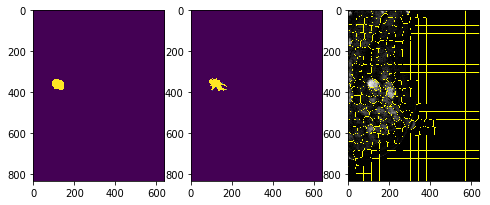

ratio:  0.5834092980856882
3091
Scale:  1


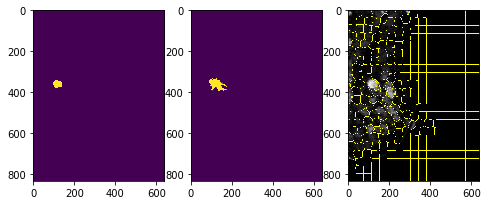

HERE:  42
PATIENT NO: 43
ratio:  0.8075877409787444
9649
Scale:  2


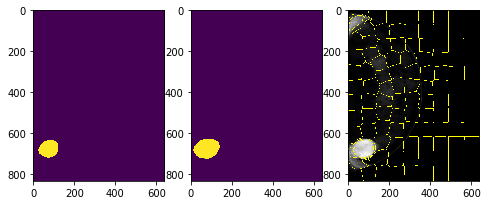

HERE:  43
PATIENT NO: 44
ratio:  0.532010243277849
7822
Scale:  2


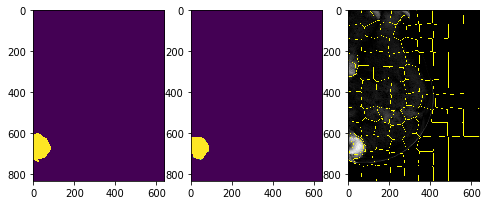

ratio:  0.6979608822305452
7822
Scale:  2


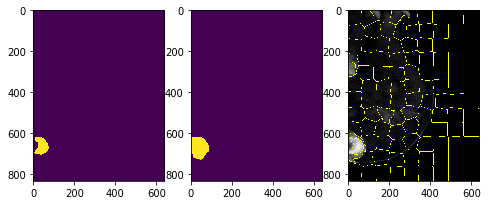

HERE:  44
PATIENT NO: 45
ratio:  0.5179609989736572
1777
Scale:  1


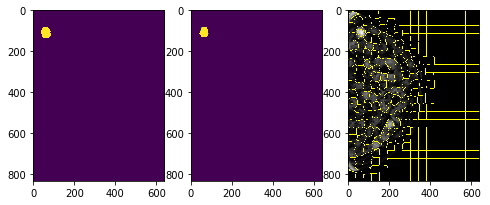

ratio:  0.6912035333087965
1777
Scale:  1


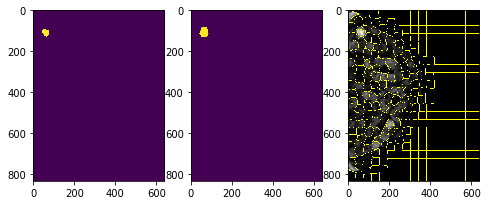

HERE:  45
PATIENT NO: 46
ratio:  0.6154390934844193
1914
Scale:  1


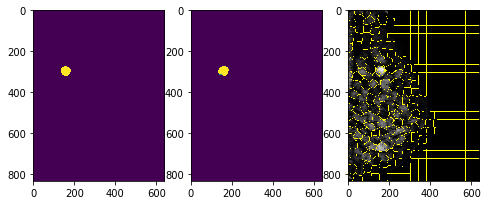

ratio:  0.6115342763873776
1914
Scale:  1


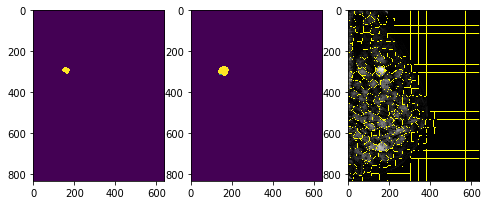

HERE:  46
PATIENT NO: 47
ratio:  0.7167926220058921
5007
Scale:  2


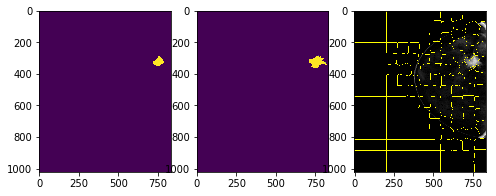

HERE:  47
PATIENT NO: 48
ratio:  0.8453703703703703
4747
Scale:  2


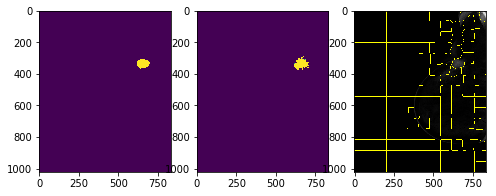

HERE:  48
PATIENT NO: 49
ratio:  0.4964918142332108
2060
Scale:  1


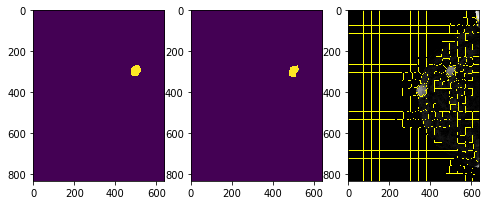

ratio:  0.7260358688930117
2060
Scale:  1


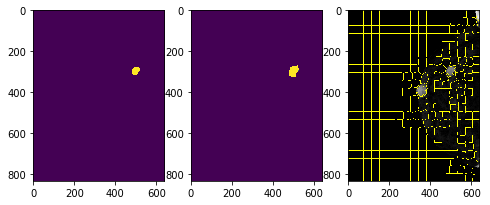

HERE:  49
PATIENT NO: 50
ratio:  0.4518140589569161
2726
Scale:  1


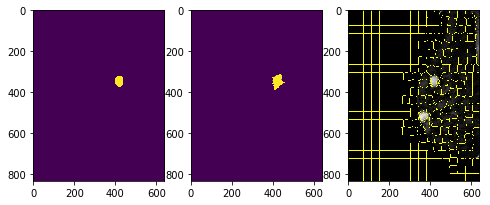

ratio:  0.544192256341789
2726
Scale:  1


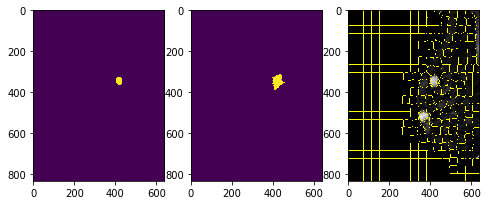

HERE:  50
PATIENT NO: 51
ratio:  0.5923449993446062
10739
Scale:  2


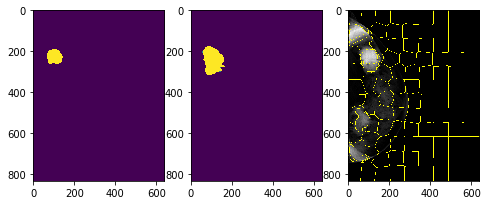

HERE:  51
PATIENT NO: 52
ratio:  0.5954756645593724
8832
Scale:  2


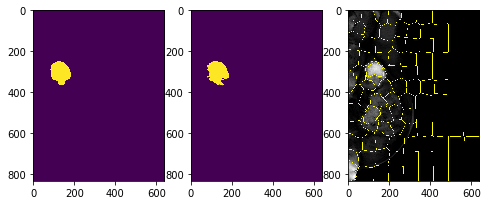

ratio:  0.6251556662515566
8832
Scale:  2


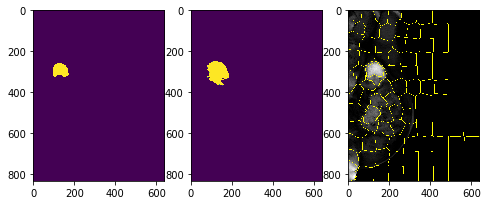

HERE:  52
PATIENT NO: 53
ratio:  0.6974808324205914
2887
Scale:  1


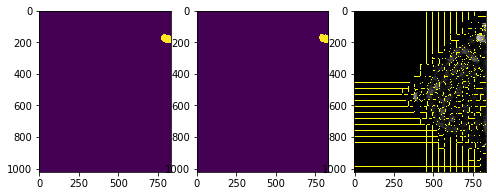

ratio:  0.5704382272839812
2887
Scale:  1


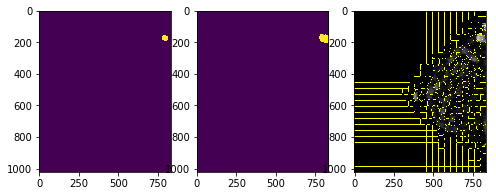

HERE:  53
PATIENT NO: 54
ratio:  0.5315775329212578
2620
Scale:  1


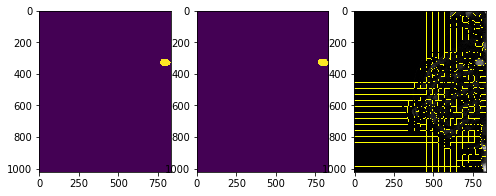

ratio:  0.7000744232200447
2620
Scale:  1


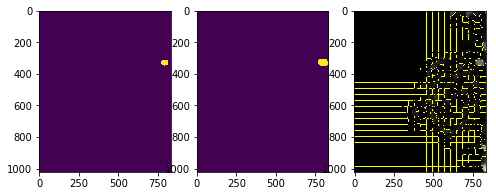

HERE:  54
PATIENT NO: 55
ratio:  0.5659655831739961
2663
Scale:  1


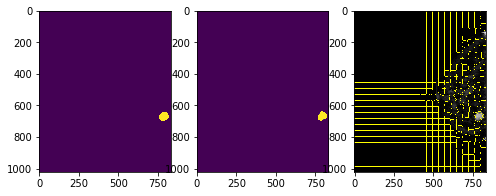

ratio:  0.672813356591079
2663
Scale:  1


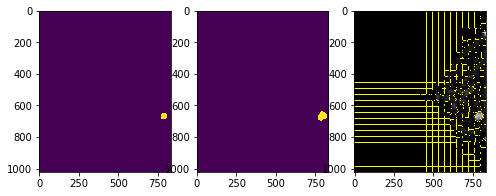

HERE:  55
PATIENT NO: 56
ratio:  0.7281344248168893
2952
Scale:  1


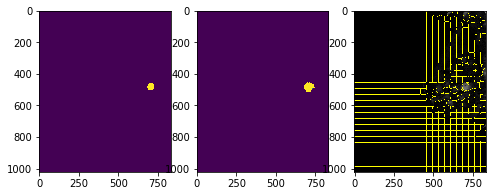

HERE:  56
PATIENT NO: 57
ratio:  0.5502323345617689
4486
Scale:  1


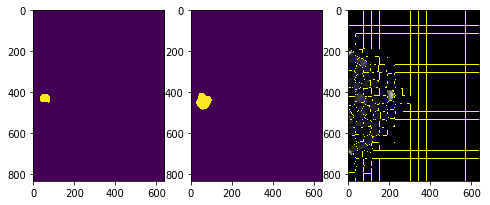

ratio:  0.4565948855989233
4486
Scale:  1


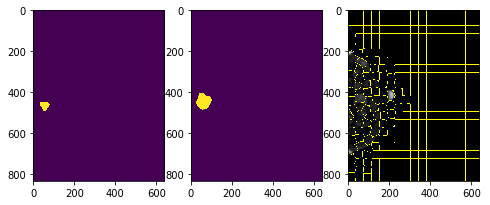

HERE:  57
PATIENT NO: 58
ratio:  0.4810628594090819
3830
Scale:  1


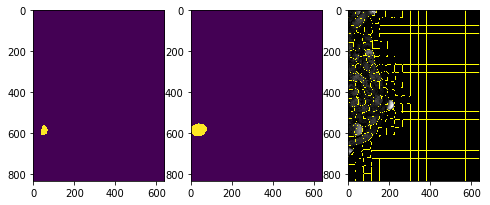

ratio:  0.4628130295612879
3830
Scale:  1


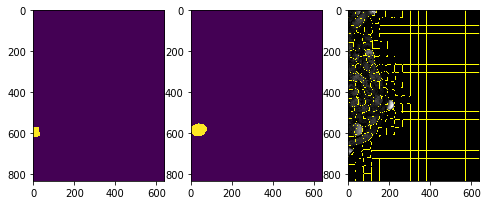

HERE:  58
PATIENT NO: 59
ratio:  0.8037182361733931
12805
Scale:  3


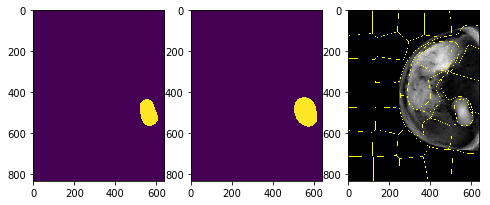

HERE:  59
PATIENT NO: 60
ratio:  0.7629744384198296
9340
Scale:  2


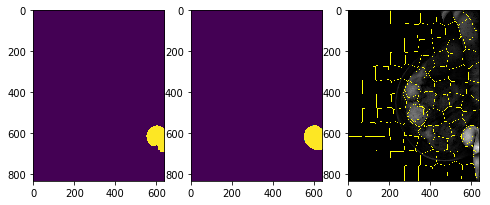

HERE:  60
PATIENT NO: 61
ratio:  0.8022030651340997
7374
Scale:  2


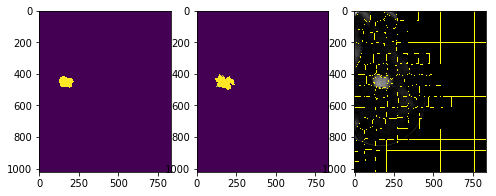

HERE:  61
PATIENT NO: 62
ratio:  0.7566472114137484
7613
Scale:  2


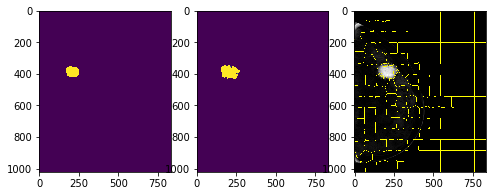

HERE:  62
PATIENT NO: 63
ratio:  0.7484486873508354
871
Scale:  1


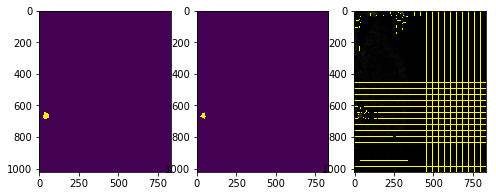

HERE:  63
PATIENT NO: 64
ratio:  0.5425742574257426
607
Scale:  1


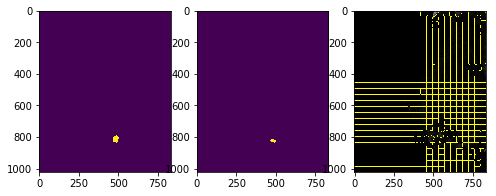

HERE:  64
PATIENT NO: 65
ratio:  0.6155321188878236
720
Scale:  1


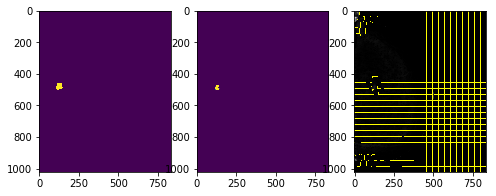

HERE:  65
PATIENT NO: 66
ratio:  0.6677524429967426
697
Scale:  1


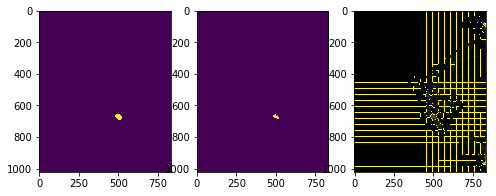

HERE:  66
PATIENT NO: 67
ratio:  0.7054105445116681
14542
Scale:  3


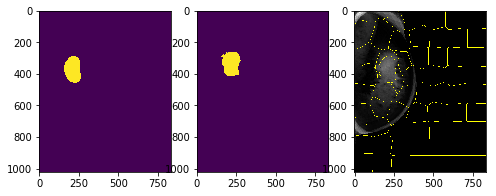

HERE:  67
PATIENT NO: 68
ratio:  0.7517364052176859
11772
Scale:  3


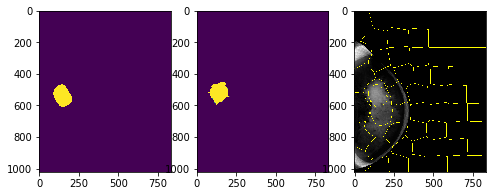

HERE:  68
PATIENT NO: 69
ratio:  0.6569659044639221
31335
Scale:  3


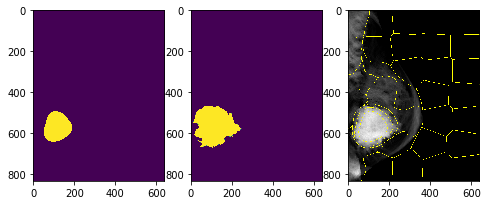

HERE:  69
PATIENT NO: 70
ratio:  0.7574896930829135
13455
Scale:  3


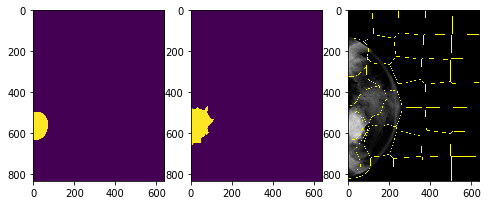

HERE:  70
PATIENT NO: 71
ratio:  0.776530939403655
1646
Scale:  1


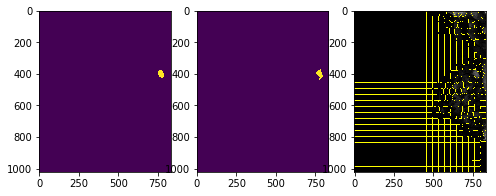

HERE:  71
PATIENT NO: 72
ratio:  0.7657957244655582
1284
Scale:  1


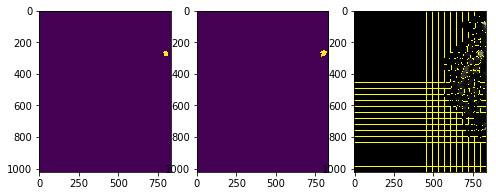

HERE:  72
PATIENT NO: 73
ratio:  0.8785273942867066
12564
Scale:  3


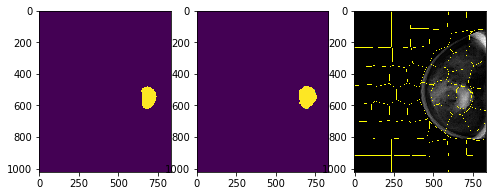

HERE:  73
PATIENT NO: 74
ratio:  0.8721155032701247
12513
Scale:  3


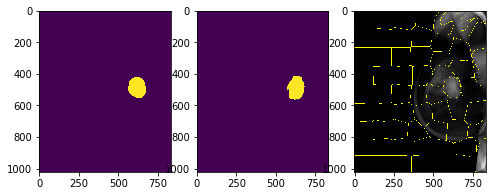

HERE:  74
PATIENT NO: 75
ratio:  0.6292498650836481
619
Scale:  1


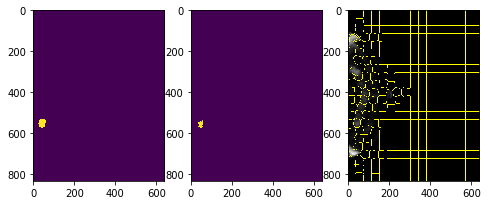

HERE:  75
PATIENT NO: 76
ratio:  0.841541755888651
946
Scale:  1


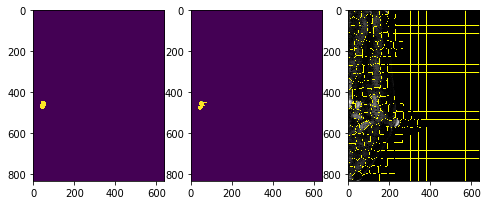

HERE:  76
PATIENT NO: 77
ratio:  0.5406864635557269
3784
Scale:  1


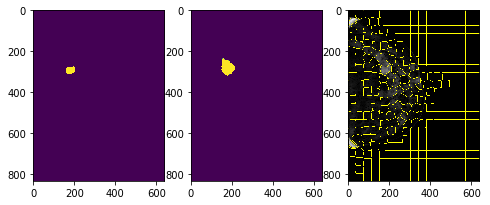

HERE:  77
PATIENT NO: 78
ratio:  0.7688470066518847
2163
Scale:  1


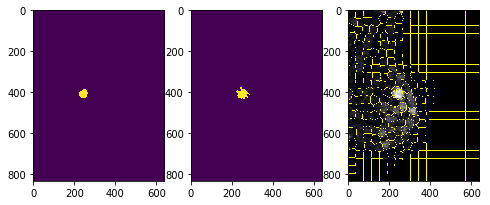

HERE:  78
PATIENT NO: 79
ratio:  0.6734221192819919
2153
Scale:  1


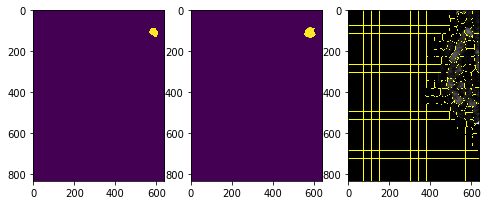

HERE:  79
PATIENT NO: 80
ratio:  0.4748363800496502
2823
Scale:  1


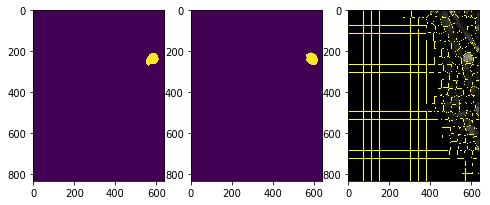

ratio:  0.5746023731380965
2823
Scale:  1


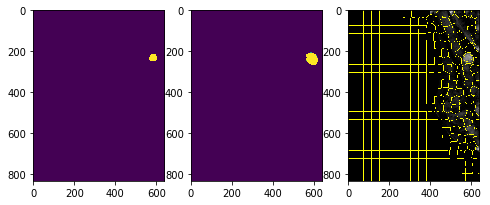

HERE:  80
PATIENT NO: 81
ratio:  0.7152317880794702
281
Scale:  0


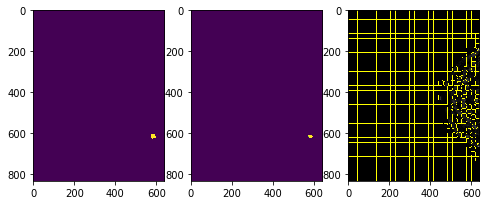

HERE:  81
PATIENT NO: 82
ratio:  0.5718232044198895
208
Scale:  0


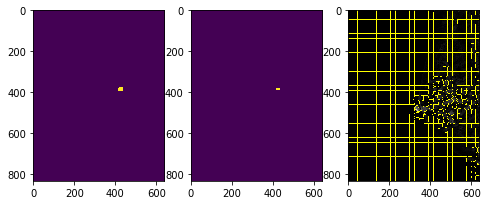

HERE:  82
PATIENT NO: 83
ratio:  0.7440559440559441
270
Scale:  0


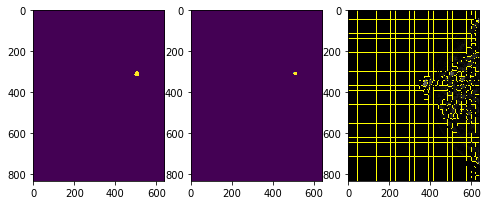

HERE:  83
PATIENT NO: 84
ratio:  0.8511669429919653
4504
Scale:  2


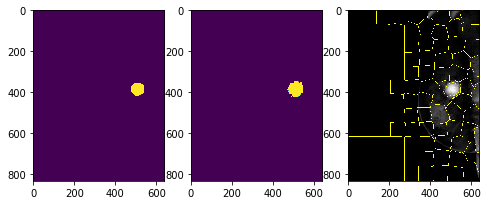

HERE:  84
PATIENT NO: 85
ratio:  0.5096077915240853
4780
Scale:  2


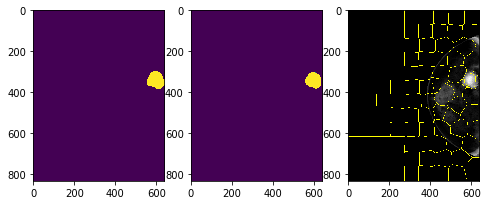

ratio:  0.742436200999737
4780
Scale:  2


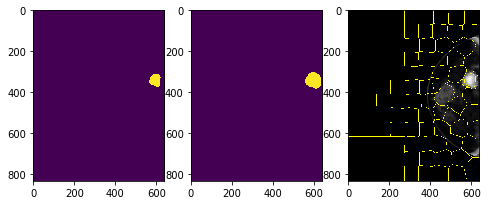

HERE:  85
PATIENT NO: 86
ratio:  0.4752
1724
Scale:  1


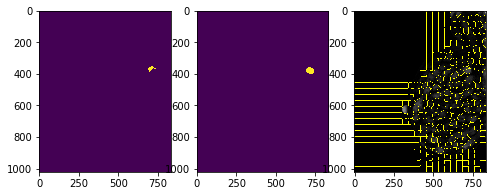

ratio:  0.7296416938110749
1724
Scale:  1


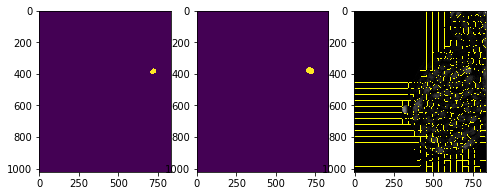

HERE:  86
PATIENT NO: 87
ratio:  0.7577435897435898
3021
Scale:  1


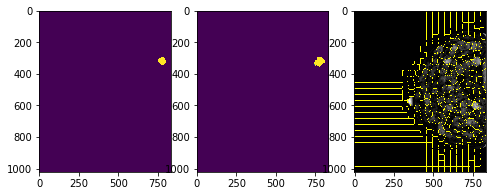

HERE:  87
PATIENT NO: 88
ratio:  0.4538844240336778
1654
Scale:  1


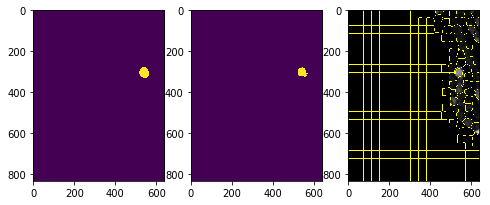

ratio:  0.768319763138416
1654
Scale:  1


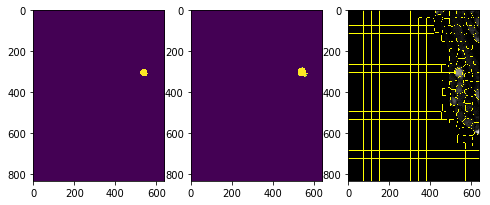

HERE:  88
PATIENT NO: 89
ratio:  0.8109575518262586
2393
Scale:  1


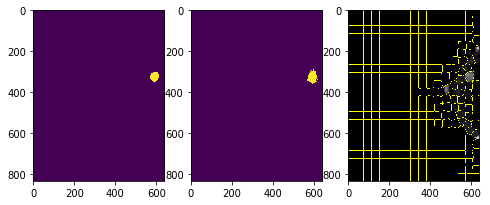

HERE:  89
PATIENT NO: 90
ratio:  0.7590023125206475
7513
Scale:  2


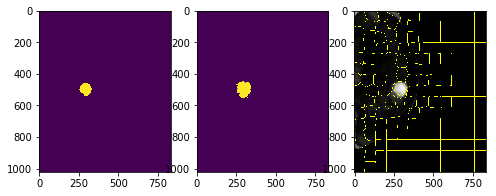

HERE:  90
PATIENT NO: 91
ratio:  0.694768162658071
7896
Scale:  2


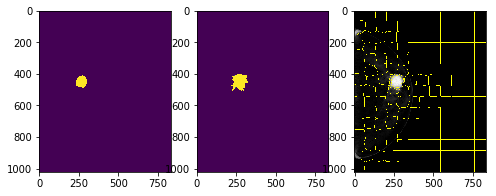

HERE:  91
PATIENT NO: 92
ratio:  0.8404163052905465
1051
Scale:  1


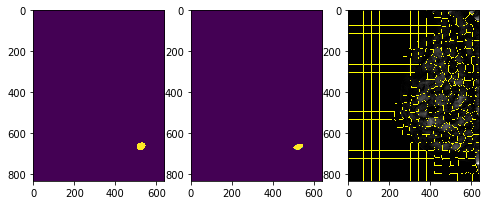

HERE:  92
PATIENT NO: 93
ratio:  0.80625
829
Scale:  1


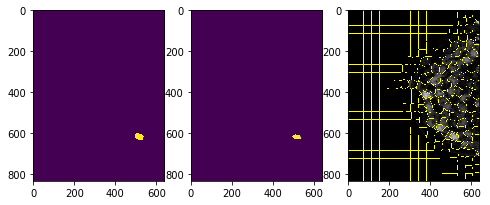

HERE:  93
PATIENT NO: 94
ratio:  0.7934318555008211
1831
Scale:  1


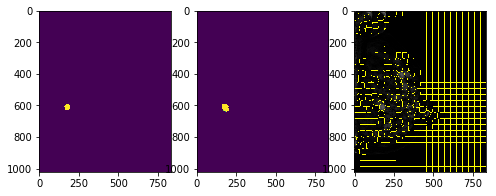

HERE:  94
PATIENT NO: 95
ratio:  0.5572979493365501
261
Scale:  0


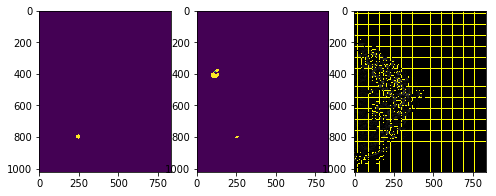

HERE:  95
PATIENT NO: 96
ratio:  0.7249536178107606
2743
Scale:  1


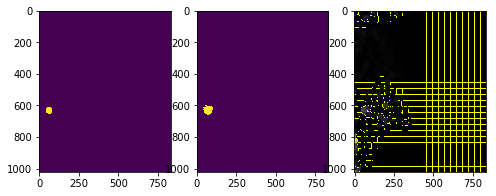

HERE:  96
PATIENT NO: 97
ratio:  0.7048818897637795
4109
Scale:  1


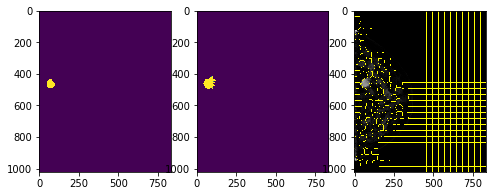

HERE:  97
PATIENT NO: 98
ratio:  0.7102593010146562
564
Scale:  0


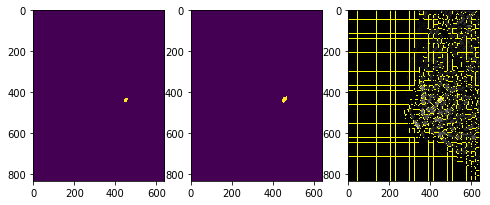

HERE:  98
PATIENT NO: 99
ratio:  0.8599640933572711
1094
Scale:  1


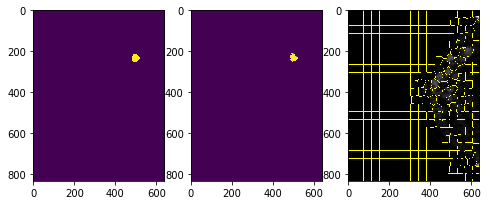

HERE:  99
PATIENT NO: 100
ratio:  0.6532966908174158
29647
Scale:  3


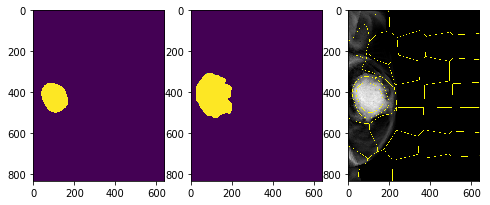

HERE:  100
PATIENT NO: 101
ratio:  0.6522170495306419
26490
Scale:  3


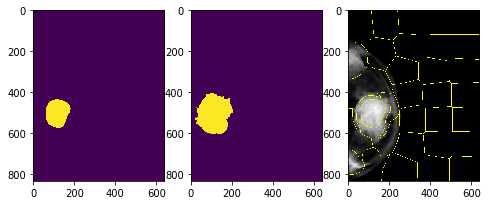

HERE:  101
PATIENT NO: 102
ratio:  0.9262405006705409
1124
Scale:  1


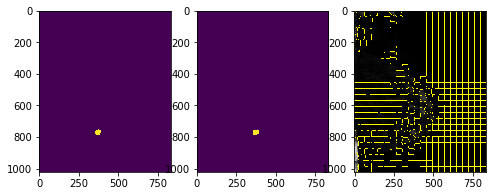

HERE:  102
PATIENT NO: 103
ratio:  0.9413379073756433
1487
Scale:  1


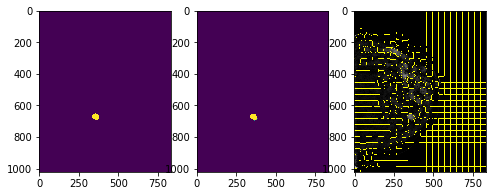

HERE:  103
PATIENT NO: 104
ratio:  0.7242564895994499
6975
Scale:  2


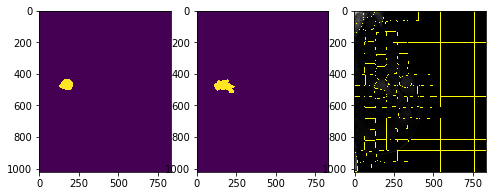

HERE:  104
PATIENT NO: 105
ratio:  0.8341839504832229
5125
Scale:  2


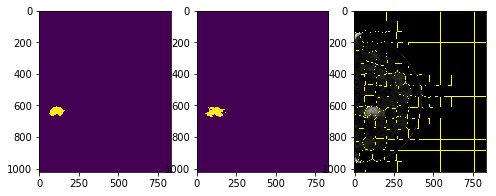

HERE:  105
PATIENT NO: 106
ratio:  0.8354002254791432
875
Scale:  1


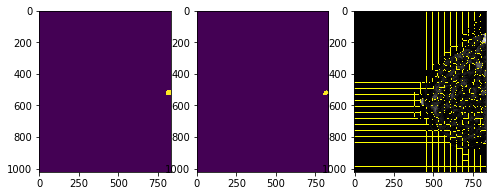

HERE:  106


In [0]:
from scipy import ndimage
from scipy.stats import skew
from scipy.stats import kurtosis
import numpy.ma as ma
import numpy as np
p_pfeatures = {}
p_nfeatures = {}
positives = get_patients(parsed,'p')
total = len(positives) -1 

if (extract_feat):

  for k in range(total):
      false_sp = []
      true_sp = []
      count_f = 0
      count_t = 0
      print("PATIENT NO: " + str(k))
      name = positives[k]
      p=findPatient(parsed=parsed, name=name)
      img=cv2.imread(parsed[p]['image'],-1)
      mask=cv2.imread(parsed[p]['mask'],-1)

      if (parsed[p]['gt'] == []):
          gt_img = np.zeros([mask.shape[0],mask.shape[1]])
      else:
          gt_img = cv2.imread(parsed[p]['gt'],-1)

      logic_mask=mask
      logic_mask[mask==255]=True
      img=np.multiply(img,logic_mask)

      near_img = cv2.resize(img,None, fx = 0.25, fy = 0.25, interpolation = cv2.INTER_CUBIC)
      gt_img = cv2.resize(gt_img,None, fx = 0.25, fy = 0.25, interpolation = cv2.INTER_CUBIC)
      logic_mask = cv2.resize(logic_mask,None, fx = 0.25, fy = 0.25, interpolation = cv2.INTER_CUBIC)
      clahe = cv2.createCLAHE(clipLimit=1, tileGridSize=(4,4))
      cl1 = clahe.apply(near_img)
      cl1=np.multiply(cl1,logic_mask)

      #pixel size is the resolution
      PixelSize =70/1000  #70 micrometer to 70 milimeter
      M = 4; #Number of cirles
      N = 18; #Nmber of angles
      Areamin = 15 #Minimum area in milimeters square
      Areamax = 3689 #Maximum area in milimeters square

      sifted_images = Multi_scale_morphological_sifters (cl1 ,M, N, Areamin, Areamax, PixelSize)


      Number_pixels = sifted_images[1].shape[0] * sifted_images[1].shape[1] * PixelSize 
      Number_pixels = 4 * Number_pixels
      DImin =   (math.sqrt(Areamin/math.pi))  #Calculate the minimum diameter
      DImax =  (math.sqrt(Areamax/math.pi))  #Calculate the maximum diameter
      S = [ 12,  20,  36, 62]
      Number_k = (np.divide(Number_pixels,(np.multiply(S,S)))).astype(np.int)
      _, contours, hierarchy = cv2.findContours(gt_img, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)

      seg = len(contours)
      mask = np.zeros([seg,gt_img.shape[0],gt_img.shape[1]] ,np.uint8)
      for i in range(seg):
          cv2.drawContours(mask[i,:,:], [contours[i]], -1, 1, -1)



      for i in range(4):

          img_thresh=sifted_images[i].astype(np.float)

          numSegments=Number_k[i]
          sigma1 = 5
          compact=10000
          if i == 1:
              compact=10000
          if i == 2:
              compact= 10000
          if i == 3:
              sigma1=20
              compact=8000

          segments = slic(img_thresh, n_segments = numSegments,enforce_connectivity=True,multichannel=False,compactness=compact,sigma=sigma1)
          img_thresh_old = img_thresh;
          img_thresh = img_thresh/65535
          #segments = felzenszwalb(img_thresh, scale=500, min_size=20,sigma=0.2)
          numRegions = segments.max()
          #store_segments[p,i] = segments
          for n_sup in range(numRegions):
              temp = (segments == n_sup)
              test = np.multiply(img_thresh,temp)
              total_int = np.sum(test)
              bound_thresh = [35,70,250,1000]
              if (total_int > bound_thresh[i]):
                  label = is_mass (temp, mask,seg,i)
                  if (label == 0):
                      if (count_f ==0):
                          features = np.expand_dims((np.asarray(extract_features(near_img,cl1,temp,i,sifted_images[i]))),axis=0)
                          features = np.append(features,[p,i,n_sup])
                          features = np.expand_dims(features,axis=0)
                          false_sp = features
                          count_f = count_f + 1
                      else:
                          features = np.expand_dims((np.asarray(extract_features(near_img,cl1,temp,i,sifted_images[i]))),axis=0)
                          features = np.append(features,[p,i,n_sup])
                          features = np.expand_dims(features,axis=0)
                          false_sp= np.concatenate((false_sp,features),axis=0)
                  if (label == 1):
                      temp = ndimage.binary_fill_holes(temp).astype(temp.dtype)
                      print('Scale: ',i)
                      plt.figure(figsize=(8,8))
                      plt.subplot(1,3,1)
                      plt.imshow(temp)
                      plt.subplot(1,3,2)
                      plt.imshow(gt_img)
                      plt.subplot(1,3,3)
                      plt.imshow(mark_boundaries(img_thresh, segments),cmap='gray')
                      plt.show()
                      if (count_t ==0):
                          features = np.expand_dims((np.asarray(extract_features(near_img,cl1,temp,i,sifted_images[i]))),axis=0)
                          features = np.append(features,[p,i,n_sup])
                          features = np.expand_dims(features,axis=0)
                          true_sp = features
                          count_t = count_t + 1  
                      else:
                          features = np.expand_dims((np.asarray(extract_features(near_img,cl1,temp,i,sifted_images[i]))),axis=0)
                          features = np.append(features,[p,i,n_sup])
                          features = np.expand_dims(features,axis=0)
                          true_sp =np.concatenate((true_sp,features),axis=0)
      print("HERE: ", k)
      p_pfeatures[k]=true_sp
      p_nfeatures[k]=false_sp

  np.save("pos_true_temp.npy",p_pfeatures)
  np.save("pos_false_temp.npy",p_nfeatures)
 
  



#### A- Negatives Feature Extraction
These are the features for all the 303 negatives cases. You **dont need to run** this as the features vectors have already been generated.

In [0]:
from scipy import ndimage
from scipy.stats import skew
from scipy.stats import kurtosis
import numpy.ma as ma
import numpy as np
n_features = {}
negatives = get_patients(parsed,'n')
total = len(negatives) #61 doesnt get detected.
print("Totl features: " , total)

if (extract_feat):
  for k in range(total):
      false_sp = []
      count_f = 0
      print("PATIENT NO: " + str(k))
      name = negatives[k]
      p=findPatient(parsed=parsed, name=name)
      img=cv2.imread(parsed[p]['image'],-1)
      mask=cv2.imread(parsed[p]['mask'],-1)

      if (parsed[p]['gt'] == []):
          gt_img = np.zeros([mask.shape[0],mask.shape[1]])
      else:
          gt_img = cv2.imread(parsed[p]['gt'],-1)

      logic_mask=mask
      logic_mask[mask==255]=True
      img=np.multiply(img,logic_mask)

      near_img = cv2.resize(img,None, fx = 0.25, fy = 0.25, interpolation = cv2.INTER_CUBIC)
      gt_img = cv2.resize(gt_img,None, fx = 0.25, fy = 0.25, interpolation = cv2.INTER_CUBIC)
      logic_mask = cv2.resize(logic_mask,None, fx = 0.25, fy = 0.25, interpolation = cv2.INTER_CUBIC)
      clahe = cv2.createCLAHE(clipLimit=1, tileGridSize=(4,4))
      cl1 = clahe.apply(near_img)
      cl1=np.multiply(cl1,logic_mask)

      #pixel size is the resolution
      PixelSize =70/1000  #70 micrometer to 70 milimeter
      M = 4; #Number of cirles
      N = 18; #Nmber of angles
      Areamin = 15 #Minimum area in milimeters square
      Areamax = 3689 #Maximum area in milimeters square

      sifted_images = Multi_scale_morphological_sifters (cl1 ,M, N, Areamin, Areamax, PixelSize)


      Number_pixels = sifted_images[1].shape[0] * sifted_images[1].shape[1] * PixelSize 
      Number_pixels = 4 * Number_pixels
      DImin =   (math.sqrt(Areamin/math.pi))  #Calculate the minimum diameter
      DImax =  (math.sqrt(Areamax/math.pi))  #Calculate the maximum diameter
      S = [ 12,  20,  36, 62]
      Number_k = (np.divide(Number_pixels,(np.multiply(S,S)))).astype(np.int)



      for i in range(4):

          img_thresh=sifted_images[i].astype(np.float)

          numSegments=Number_k[i]
          sigma1 = 5
          compact=10000
          if i == 1:
              compact=10000
          if i == 2:
              compact= 10000
          if i == 3:
              sigma1=20
              compact=8000

          segments = slic(img_thresh, n_segments = numSegments,enforce_connectivity=True,multichannel=False,compactness=compact,sigma=sigma1)
          img_thresh_old = img_thresh;
          img_thresh = img_thresh/65535
          #segments = felzenszwalb(img_thresh, scale=500, min_size=20,sigma=0.2)
          numRegions = segments.max()

          for n_sup in range(numRegions):
              temp = (segments == n_sup)
              test = np.multiply(img_thresh,temp)
              total_int = np.sum(test)
              bound_thresh = [35,70,250,1000]
              if (total_int > bound_thresh[i]):
                if (count_f ==0):
                    features = np.expand_dims((np.asarray(extract_features(near_img,cl1,temp,i,sifted_images[i]))),axis=0)
                    features = np.append(features,[p,i,n_sup])
                    features = np.expand_dims(features,axis=0)
                    false_sp = features
                    count_f = count_f + 1
                else:
                    features = np.expand_dims((np.asarray(extract_features(near_img,cl1,temp,i,sifted_images[i]))),axis=0)
                    features = np.append(features,[p,i,n_sup])
                    features = np.expand_dims(features,axis=0)
                    false_sp= np.concatenate((false_sp,features),axis=0)

      n_features[k]=false_sp


  np.save("neg_false.npy",n_features)
#95 missing case scale 2

# 35 - 50 range - 81 -82  --- 81 in the range of 40+ --- 82 in the range of 35 - 40 ---


Totl features:  303
PATIENT NO: 0
PATIENT NO: 1
PATIENT NO: 2
PATIENT NO: 3
PATIENT NO: 4
PATIENT NO: 5
PATIENT NO: 6
PATIENT NO: 7
PATIENT NO: 8
PATIENT NO: 9
PATIENT NO: 10
PATIENT NO: 11
PATIENT NO: 12
PATIENT NO: 13
PATIENT NO: 14
PATIENT NO: 15
PATIENT NO: 16
PATIENT NO: 17
PATIENT NO: 18
PATIENT NO: 19
PATIENT NO: 20
PATIENT NO: 21
PATIENT NO: 22
PATIENT NO: 23
PATIENT NO: 24
PATIENT NO: 25
PATIENT NO: 26
PATIENT NO: 27
PATIENT NO: 28
PATIENT NO: 29
PATIENT NO: 30
PATIENT NO: 31
PATIENT NO: 32
PATIENT NO: 33
PATIENT NO: 34
PATIENT NO: 35
PATIENT NO: 36
PATIENT NO: 37
PATIENT NO: 38
PATIENT NO: 39
PATIENT NO: 40
PATIENT NO: 41
PATIENT NO: 42
PATIENT NO: 43
PATIENT NO: 44
PATIENT NO: 45
PATIENT NO: 46
PATIENT NO: 47
PATIENT NO: 48
PATIENT NO: 49
PATIENT NO: 50
PATIENT NO: 51
PATIENT NO: 52
PATIENT NO: 53
PATIENT NO: 54
PATIENT NO: 55
PATIENT NO: 56
PATIENT NO: 57
PATIENT NO: 58
PATIENT NO: 59
PATIENT NO: 60
PATIENT NO: 61
PATIENT NO: 62
PATIENT NO: 63
PATIENT NO: 64
PATIENT NO: 65


#### B- Loading the saved feature vectors for positive and negative cases

In [0]:
t_sel = np.load('neg_false.npy', allow_pickle=True)
n_features = t_sel[()]

t_sel = np.load("pos_true_temp.npy",allow_pickle=True)
p_pfeatures = t_sel[()]

t_sel = np.load("pos_false_temp.npy",allow_pickle=True)
p_nfeatures = t_sel[()]


## Classification

#### Function Create ensamble SVM

In [0]:
from scipy import interp
from sklearn import svm, datasets
from sklearn.metrics import roc_curve, auc
rnd = np.random.RandomState(357)
from sklearn.ensemble import RandomForestClassifier


# This function splits the data.
def split_Data(X,porcentaje4test):
    n_test=np.int(len(X)*porcentaje4test)
    n_train=len(X)-n_test
  #  shuffled_indices = rnd.permutation(np.arange(X.shape[0]))  
  #  X_shuffled = X[shuffled_indices]
    np.random.shuffle(X)
    X_train,X_test = X[:n_train], X[n_train:]
    return X_train,X_test

  
#This function concatenates and shuffles the positive and negative feature vectors
def concat_and_shuffled(X_true,X_false,shuffed=True):
    Y_false=np.zeros(X_false.shape[0])
    Y_true=np.ones(X_true.shape[0])
    Y=np.concatenate([Y_true,Y_false])
    X=np.concatenate([X_true,X_false])
    if shuffed:
        shuffled_indices = rnd.permutation(np.arange(Y.shape[0]))
        return X[shuffled_indices], Y[shuffled_indices]
    else:
        return X, Y

# This function measures the performance of the system
def perf_measure(y_actual, y_hat):
    TP = 0
    FP = 0
    TN = 0
    FN = 0
    for i in range(len(y_hat)): 
        if y_actual[i]==y_hat[i]==1:
            TP += 1
        if y_hat[i]==1 and y_actual[i]!=y_hat[i]:
            FP += 1
        if y_actual[i]==y_hat[i]==0:
            TN += 1
        if y_hat[i]==0 and y_actual[i]!=y_hat[i]:
            FN += 1
    print("TP ",TP," FP ",FP," TN ",TN," FN ",FN)
   # return(TP, FP, TN, FN)
   
    
# this is the function that creates an ensemble of SVMS provided on the default ratio of 
# False Superpixels/ True Superpixels. The ratio is the divided by 10. In the first layer we
# use almost 50-60 ensembles. In the second layer around 5 - 10. In the last layer, only one.
def layer_of_cascade(X_train,Y_train,X_test,Y_test,threshold,n_classifier=None):
    
    X_true_train=X_train[Y_train==True,:]
    X_false_train=X_train[Y_train==False,:]
    ratio=X_false_train.shape[0]/X_true_train.shape[0]
    print("Initial Ratio=",ratio)
    # Splitting the False regions in N differents sets
    if n_classifier==None:
        n_classifier=round(ratio/10)
    X_false_split=np.array_split(X_false_train,n_classifier) 
    
    predict_test=np.empty([Y_test.shape[0],len(X_false_split)])
    predict_train=np.empty([Y_train.shape[0],len(X_false_split)])
    for i,X_false_split_loop in enumerate(X_false_split):
        X_train_loop,Y_train_loop=concat_and_shuffled(X_true_train,X_false_split_loop)
        clf = svm.SVC(gamma='scale',probability=True,class_weight='balanced')
        #clf = RandomForestClassifier(random_state=0, n_jobs=-1, class_weight="balanced")
        clf.fit(X_train_loop, Y_train_loop)  
        predict_test[:,i] = clf.predict_proba(X_test)[:,1]
        predict_train[:,i]=clf.predict_proba(X_train)[:,1]
    if predict_test.shape[1]>1:
        prediction_test=np.mean(predict_test,axis=1)>threshold
        prediction_train=np.mean(predict_train,axis=1)>threshold
    else:
        prediction_test=predict_test>threshold
        prediction_train=predict_train>threshold
    print("Test")
    perf_measure(Y_test,prediction_test)
    print("Training")
    perf_measure(Y_train,prediction_train)
    return prediction_test.astype(bool),prediction_train.astype(bool),clf


#### Functions  for fROC Calculation and Assigning of Labels to the masses

In [0]:
# This function is used to asses the super pixel label. If the ratio is greater
# then 0.2 of the assignmed super pixel, it is a mass. Otherwise it is classified as false.

def dice_mass (superpixel,gt,seg):
    k=1.0
    ratio=0
    for j in range(seg): 
        num = 0
        test = np.sum(superpixel[gt[j,:,:]==k]==k)*2.0
        if (test > num):
            num = test
            den1 = (np.sum(superpixel[superpixel==k]==k))
            den2 = np.sum(gt[j,:,:][gt[j,:,:]==k]==k)
            ratio = (num / (den1 + den2))
            #print("den1",den1)
            #print("den2",den2)
            #print("num",num)
    return ratio>=0.2

  
# This function plots the fROC of the system
def plotFROC(x,y,threshold_list=None):
    plt.figure()
    plt.plot(x,y, 'o-') 
    plt.xlabel('FPavg')
    plt.ylabel('Sensitivity')
    
    #annotate thresholds
    if threshold_list != None:
        #round thresholds
        threshold_list = [ '%.2f' % elem for elem in threshold_list ]            
        xy_buffer = None
        for i, xy in enumerate(zip(x, y)):
            if xy != xy_buffer:                                    
                plt.annotate(str(threshold_list[i]), xy=xy, textcoords='data')
                xy_buffer = xy
    
    #plt.savefig(save_path)
    plt.show()  

        
def computeFROC(proba_map, ground_truth, nbr_of_thresholds=40, range_threshold=None):
    #INPUTS
    #proba_map : numpy array of dimension [number of image, xdim, ydim,...], values preferably in [0,1]
    #ground_truth: numpy array of dimension [number of image, xdim, ydim,...], values in {0,1}
    #nbr_of_thresholds: Interger. number of thresholds to compute to plot the FROC
    #range_threshold: list of 2 floats. Begining and end of the range of thresholds with which to plot the FROC  
    #OUTPUTS
    #sensitivity_list_treshold: list of average sensitivy over the set of images for increasing thresholds
    #FPavg_list_treshold: list of average FP over the set of images for increasing thresholds
    #threshold_list: list of thresholds
            
    #rescale ground truth and proba map between 0 and 1
    #proba_map = proba_map.astype(np.float32)
    #proba_map = (proba_map - np.min(proba_map)) / (np.max(proba_map) - np.min(proba_map))
    max_prob=0
    for heat_map in heat_map_list:
      max_loop=np.max(heat_map)
      if max_prob<max_loop: 
        max_prob= max_loop
    
    #define the thresholds
    if range_threshold == None:
        threshold_list = (np.linspace(0,max_prob,nbr_of_thresholds)).tolist()
    else:
        threshold_list = (np.linspace(range_threshold[0],range_threshold[1],nbr_of_thresholds)).tolist()
    
    TP_list_treshold = np.zeros(nbr_of_thresholds)
    FP_list_treshold = np.zeros(nbr_of_thresholds)
    P_list_treshold = np.zeros(nbr_of_thresholds)
    #loop over thresholds
    for t,threshold in enumerate(threshold_list):
        TP=0
        FP=0
        P = 0
        #print("threshold ", threshold )
        #loop over all the images
        for i in range(len(proba_map)):

            #threshold the proba map
            thresholded_proba_map = np.zeros(np.shape(proba_map[i]))
            thresholded_proba_map[proba_map[i] > threshold] = 1
            if (False):
              plt.figure
              plt.imshow(thresholded_proba_map,cmap='gray')
              plt.show()
            if(np.sum(thresholded_proba_map)==0):
                num_sp=0
            else:
                _, sp_contours, _ = cv2.findContours(thresholded_proba_map.astype("uint8"), cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
                num_sp = len(sp_contours)
            if(np.sum(ground_truth[i])==0):
                FP+=num_sp
            else:
                _,gt_contours,_ = cv2.findContours(ground_truth[i], cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
                new_gt_contours=[]
                for contour in gt_contours:
                  if (contour.shape[0]>10):
                      new_gt_contours.append(contour)
                P += len(new_gt_contours)
                gt_mask = np.zeros([P,thresholded_proba_map.shape[0],thresholded_proba_map.shape[1]] ,np.uint8)
                for i in range(len(new_gt_contours)):
                    cv2.drawContours(gt_mask[i,:,:], [new_gt_contours[i]], -1, 1, -1)
                # For each predicted region
                sp_mask = np.zeros([num_sp,thresholded_proba_map.shape[0],thresholded_proba_map.shape[1]] ,np.uint8)
                for i in range(num_sp):
                    cv2.drawContours(sp_mask[i,:,:], [sp_contours[i]], -1, 1, -1)   
                    match=dice_mass(sp_mask[i,:,:],gt_mask,P)            
                    if match:
                        TP+=1 ## We dont take in account the False Positive in Positive Images
        #print("TP",TP)
        #print("P",P)
        #print("FP",FP)
        TP_list_treshold[t]=TP
        FP_list_treshold[t]=FP
        P_list_treshold[t]=P
            
    return TP_list_treshold,FP_list_treshold,P_list_treshold, threshold_list
  
  
# This function returns all the superpixel segments of one patients. This is used 
# to generate heat maps for fixing the probability threshold and calculating the 
# fROC in an efficient way

def get_all_superpixel(parsed,p):
  img=cv2.imread(parsed[p]['image'],-1)
  mask=cv2.imread(parsed[p]['mask'],-1)

  if (parsed[p]['gt'] == []):
      gt_img = np.zeros([mask.shape[0],mask.shape[1]])
  else:
      gt_img = cv2.imread(parsed[p]['gt'],-1)

  logic_mask=mask
  logic_mask[mask==255]=True
  img=np.multiply(img,logic_mask)

  near_img = cv2.resize(img,None, fx = 0.25, fy = 0.25, interpolation = cv2.INTER_CUBIC)
  gt_img = cv2.resize(gt_img,None, fx = 0.25, fy = 0.25, interpolation = cv2.INTER_CUBIC)
  logic_mask = cv2.resize(logic_mask,None, fx = 0.25, fy = 0.25, interpolation = cv2.INTER_CUBIC)
  clahe = cv2.createCLAHE(clipLimit=1, tileGridSize=(4,4))
  cl1 = clahe.apply(near_img)
  cl1=np.multiply(cl1,logic_mask)

  PixelSize =70/1000  #70 micrometer to 70 milimeter
  M = 4; #Number of cirles
  N = 18; #Nmber of angles
  Areamin = 15 #Minimum area in milimeters square
  Areamax = 3689 #Maximum area in milimeters square

  sifted_images = Multi_scale_morphological_sifters (cl1 ,M, N, Areamin, Areamax, PixelSize)


  Number_pixels = sifted_images[1].shape[0] * sifted_images[1].shape[1] * PixelSize 
  Number_pixels = 4 * Number_pixels
  DImin =   (math.sqrt(Areamin/math.pi))  #Calculate the minimum diameter
  
  DImax =  (math.sqrt(Areamax/math.pi))  #Calculate the maximum diameter
  S = [ 12,  20,  36, 62]
  Number_k = (np.divide(Number_pixels,(np.multiply(S,S)))).astype(np.int)
  segments=[]
  for scale in range(4): 
    img_thresh=sifted_images[scale].astype(np.float)

    numSegments=Number_k[scale]
    sigma_i = [5,5,5,20]
    compact=[10000, 10000, 10000,8000]

    segments.append(slic(img_thresh, n_segments = numSegments,enforce_connectivity=True,multichannel=False,compactness=compact[scale],sigma=sigma_i[scale]))
  return segments

## 10- Fold Cross Validation
Fold Cross Validation, fROC Generation and Heat Maps Calculation

Cross Validation Part:  0
Data Preparation Finished, proceeding to training stage
Done
Initial Ratio= 550.6147540983607
Test
TP  14  FP  1274  TN  6410  FN  0
Training
TP  121  FP  10905  TN  56270  FN  1
Initial Ratio= 90.12396694214875
Test
TP  14  FP  619  TN  655  FN  0
Training
TP  121  FP  5056  TN  5849  FN  0
Initial Ratio= 41.78512396694215
Test
TP  11  FP  105  TN  514  FN  3
Training
TP  115  FP  735  TN  4321  FN  6
Heat map creation of:  116
Calculating FROC
Cross Validation Part:  1
Data Preparation Finished, proceeding to training stage
Done
Initial Ratio= 533.5081967213115
Test
TP  14  FP  1555  TN  8216  FN  0
Training
TP  120  FP  10883  TN  54205  FN  2
Initial Ratio= 90.69166666666666
Test
TP  14  FP  680  TN  875  FN  0
Training
TP  120  FP  4977  TN  5906  FN  0
Initial Ratio= 41.475
Test
TP  14  FP  129  TN  551  FN  0
Training
TP  113  FP  815  TN  4162  FN  7
Heat map creation of:  143
Calculating FROC
Cross Validation Part:  2
Data Preparation Finished, procee

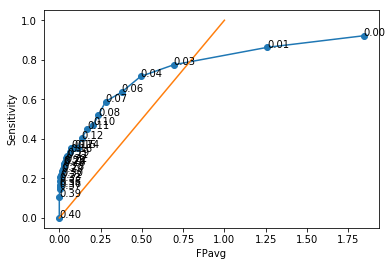

In [0]:
from numpy import *
## Parameters
threshold_1=0.03
threshold_2=0.02
threshold_3 = 0.02

calculate_FROC=True
result_plot=False

loops_cv=10
n_positive=len(p_nfeatures)
n_negative=len(n_features) 
step_posit=np.ceil(n_positive/loops_cv)
step_neg=np.ceil(n_negative/loops_cv)

nbr_of_thresholds = 30
TP_list=np.zeros(nbr_of_thresholds)
FP_list=np.zeros(nbr_of_thresholds)
P_list=np.zeros(nbr_of_thresholds)
total_images=0

for i in range(loops_cv):#loops_cv):
    print("Cross Validation Part: ", i)
    p_start_true_val=np.int(i*step_posit)
    p_start_false_val=np.int(i*step_neg)

    if ( i==loops_cv-1 ):
        p_stop_true_val=np.int(n_positive)
        p_stop_false_val=np.int(n_negative)
    else:
        p_stop_true_val=np.int((i+1)*step_posit)
        p_stop_false_val=np.int((i+1)*step_neg)
    # Validation
    true_val, false_sp_t_val = get_feature_vector_postive(p_nfeatures,p_pfeatures,p_start_true_val,p_stop_true_val)
    false_sp_f_val = get_feature_vector_negative(n_features,p_start_false_val,p_stop_false_val)
    false_val = np.concatenate((false_sp_f_val,false_sp_t_val),axis=0)
    # Training
    if  (i==0):
        true_train, false_sp_t_train = get_feature_vector_postive(p_nfeatures,p_pfeatures,p_stop_true_val,n_positive)
        false_sp_f_train = get_feature_vector_negative(n_features,p_stop_false_val,n_negative)
        false_train = np.concatenate((false_sp_t_train,false_sp_f_train),axis=0)
    else:
        if (i==loops_cv-1):
            true_train, false_sp_t_train = get_feature_vector_postive(p_nfeatures,p_pfeatures,0,p_start_true_val)
            false_sp_f_train = get_feature_vector_negative(n_features,0,p_start_false_val)
            false_train = np.concatenate((false_sp_t_train,false_sp_f_train),axis=0)
        else:
            true_sp_1_train, false_sp_t_1_val = get_feature_vector_postive(p_nfeatures,p_pfeatures,0,p_start_true_val)
            true_sp_2_train, false_sp_t_2_val = get_feature_vector_postive(p_nfeatures,p_pfeatures,p_stop_true_val,n_positive)
            false_sp_f_1_train = get_feature_vector_negative(n_features,0,p_start_false_val)
            false_sp_f_2_train = get_feature_vector_negative(n_features,p_stop_false_val,n_negative)
            false_train = np.concatenate((false_sp_t_1_val,false_sp_t_2_val,false_sp_f_1_train,false_sp_f_2_train),axis=0)
            true_train = np.concatenate((true_sp_1_train,true_sp_2_train),axis=0)    
            
    print("Data Preparation Finished, proceeding to training stage") 
    X_val, Y_val= concat_and_shuffled(true_val, false_val,shuffed=True)

    X_train,Y_train = concat_and_shuffled(X_true=true_train,X_false=false_train,shuffed=True)

    # Normalize to Mean=0 and Standard Deviation=1 
    where_are_NaNs = isnan(X_train)
    X_train[where_are_NaNs] = 0
    where_are_NaNs = isnan(X_val)
    X_val[where_are_NaNs] = 0    
    
    mean_X  = np.mean(X_train[:,:feature_limit], 0)
    std_X   = np.std(X_train[:,:feature_limit],0)
    
 
    X_train[:,:feature_limit] = (X_train[:,:feature_limit]-mean_X)/std_X
    X_val[:,:feature_limit]  = (X_val[:,:feature_limit]-mean_X)/std_X
  
    
    print("Done")
    # First Layer of SVM
    prediction_test, prediction_train, _ = layer_of_cascade(X_train[:,:feature_limit],Y_train,X_val[:,:feature_limit],Y_val,threshold_1)
 
    X_val, Y_val = X_val[prediction_test,:], Y_val[prediction_test]
    X_train, Y_train = X_train[prediction_train,:], Y_train[prediction_train]

    # Second Layer of SVM
    prediction_test, prediction_train, _ = layer_of_cascade(X_train[:,:feature_limit],Y_train,X_val[:,:feature_limit],Y_val,threshold_2)
    X_val, Y_val = X_val[prediction_test,:], Y_val[prediction_test]
    X_train, Y_train = X_train[prediction_train,:], Y_train[prediction_train]
       
    # Last Layer
    prediction_test, _, clf_last = layer_of_cascade(X_train[:,:feature_limit],Y_train,X_val[:,:feature_limit],Y_val,threshold_3,1)
    X_val, Y_val = X_val[prediction_test[:,0],:], Y_val[prediction_test[:,0]]
    predictions = clf_last.predict_proba(X_val[:,:feature_limit])[:,1]    
    
    # Sort of patient in Validation and Prediction
    index_sort=np.argsort(X_val[:,index_patient])
    X_val=X_val[index_sort,:]
    predictions= predictions[index_sort]
    
    if (calculate_FROC):
    # Heat map creation
      heat_map_list=[]
      gt_list=[]
      patient_old=-1
      print("Heat map creation of: ",len(predictions))
      for sp in range(len(predictions)):
          patient_id=(np.int(X_val[sp,index_patient]))
          scale_id = np.int(X_val[sp, index_sifted_scale])
          sp_id= np.int(X_val[sp, index_superpixel])
          if patient_id!=patient_old:  
            all_sp=get_all_superpixel(parsed,patient_id)
            mask_s=all_sp[scale_id]==sp_id
            heat_map_list.append(np.zeros([mask_s.shape[0],mask_s.shape[1]]))
            heat_map_list[-1]+= mask_s * predictions[sp]
            if (parsed[patient_id]['gt'] == []):
              gt_img=(np.zeros([mask_s.shape[0],mask_s.shape[1]]))
            else:
              gt_img=(cv2.imread(parsed[patient_id]['gt'],-1))
            gt_list.append( cv2.resize(gt_img,None, fx = 0.25, fy = 0.25, interpolation = cv2.INTER_CUBIC))
          else: 
            mask_s=all_sp[scale_id]==sp_id
            heat_map_list[-1]+= mask_s * predictions[sp]
          patient_old=patient_id

      print("Calculating FROC")
      TP, FP,P,threshold_list = computeFROC(proba_map=heat_map_list,ground_truth=gt_list, nbr_of_thresholds=nbr_of_thresholds)
      TP_list=np.sum((TP_list,TP),axis=0)
      FP_list=np.sum((FP_list,FP),axis=0)
      P_list=np.sum((P_list,P),axis=0)
      total_images+=len(heat_map_list)
    if result_plot:
      for j in range(len(heat_map_list)):
        plt.figure(figsize=(14,14))
        plt.subplot(121)
        plt.imshow(heat_map_list[j])
        plt.subplot(122)
        plt.imshow(gt_list[j])
        plt.show()
        plt.savefig("aheatmap" + str(i) + ".png")

if (calculate_FROC):
  #plot FROC
  FPavg_list=FP_list/total_images
  sensitivity_list=TP_list/P_list
    

## Results

###Sensitivity of the fROC

In [0]:
sensitivity_list

array([0.92156863, 0.8627451 , 0.7745098 , 0.71568627, 0.6372549 ,
       0.58823529, 0.51960784, 0.47058824, 0.45098039, 0.40196078,
       0.35294118, 0.35294118, 0.35294118, 0.33333333, 0.31372549,
       0.30392157, 0.28431373, 0.2745098 , 0.2745098 , 0.26470588,
       0.24509804, 0.23529412, 0.21568627, 0.20588235, 0.18627451,
       0.16666667, 0.15686275, 0.14705882, 0.10784314, 0.        ])

###False Positive Per Image 

In [0]:
FPavg_list

array([1.84307692, 1.25846154, 0.69230769, 0.49230769, 0.37846154,
       0.28      , 0.23692308, 0.20615385, 0.16923077, 0.13538462,
       0.11076923, 0.08923077, 0.07076923, 0.06461538, 0.04923077,
       0.04307692, 0.03692308, 0.03076923, 0.02769231, 0.02769231,
       0.02153846, 0.01538462, 0.01230769, 0.00615385, 0.00307692,
       0.00307692, 0.00307692, 0.00307692, 0.        , 0.        ])

###Corresponding fROC

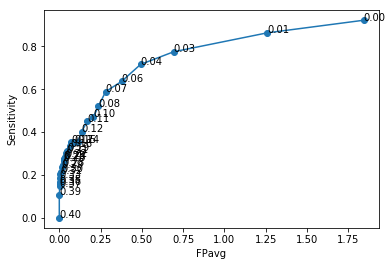

In [0]:
plotFROC(FPavg_list,sensitivity_list, threshold_list)
